# Modeling TF-IDF + NB (MNB - Multinomial Naive Bayes and CNB - Complement Naive Bayes) Notebook

**Based on the developed pipeline in `template_logreg_tfidf.ipynb`**

In [1]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import os

from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import (
    fbeta_score,
    make_scorer
)
from joblib import dump, load
from scipy.stats import loguniform, randint

sys.path.append(os.path.abspath('..'))
from src.evaluation_visualization import (
    plot_learning_curves,
    plot_confusion_matrix,
    plot_roc_and_pr_curves,
    plot_threshold_curves,
    extended_classification_report,
    get_metrics_dict
)
from src.preprocessing import process_file
from src.optimize_threshold import (
    optimize_threshold_with_cv,
    get_threshold_evaluation_data,
    get_threshold_evaluation_data_cv
)
from src.optuna_optimizer import (
    optimize_with_optuna,
    sample_class_weight_value
)
from src.optuna_visualizations import (
    plot_optuna_study_analysis,
    quick_optuna_analysis
)

from src.phrase_transformer import PhraseDetector

c:\Users\tdoro\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**a) MNB and CNB basic preprocessed data**

In [2]:
# Load and preprocess data (basic mode)
df_basiccleaned = process_file(
    filepath='../05modeling_pipelines/1klabeled_segments.csv',
    file_format='csv',
    text_key='SegmentText', 
    mode='basic'  # basic cleaning mode
)

# Map labels to binary values
df_basiccleaned['Label'] = df_basiccleaned['Label'].map({"['relevant']": 1, "['irrelevant']": 0})

MNB

Best parameters found by Optuna TPE: {'alpha': 0.0005621058074018536, 'fit_prior': False, 'tfidf_use_idf': False, 'tfidf_sublinear_tf': True, 'select__k': 151}
Best F2 score during optimization: 0.850

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


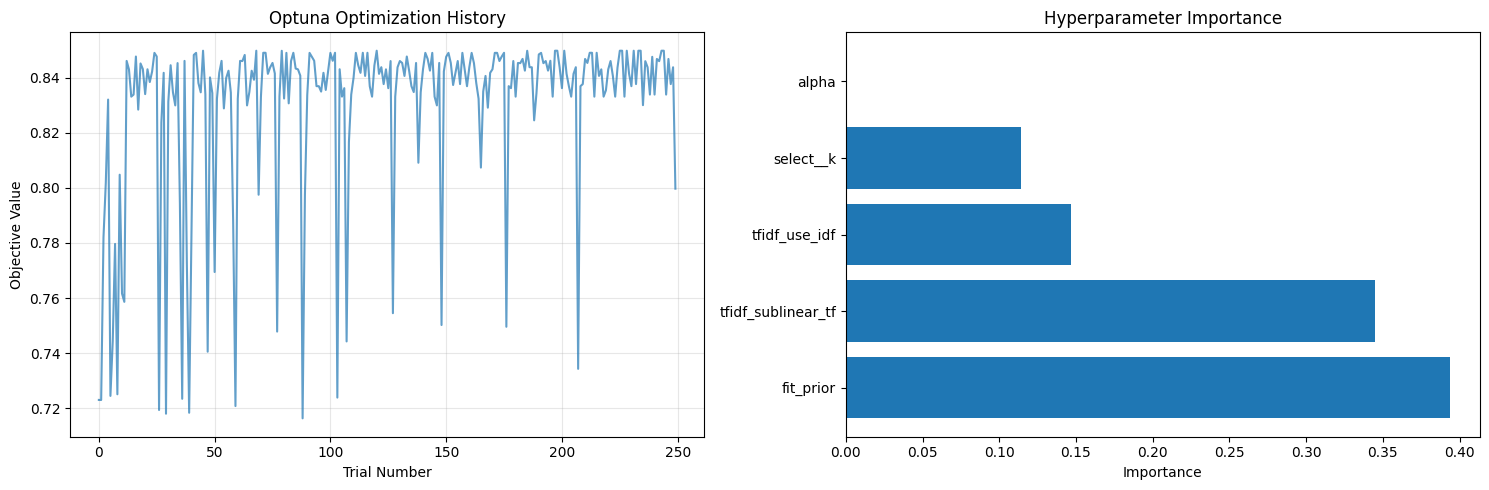


2. Parameter Value Distributions:


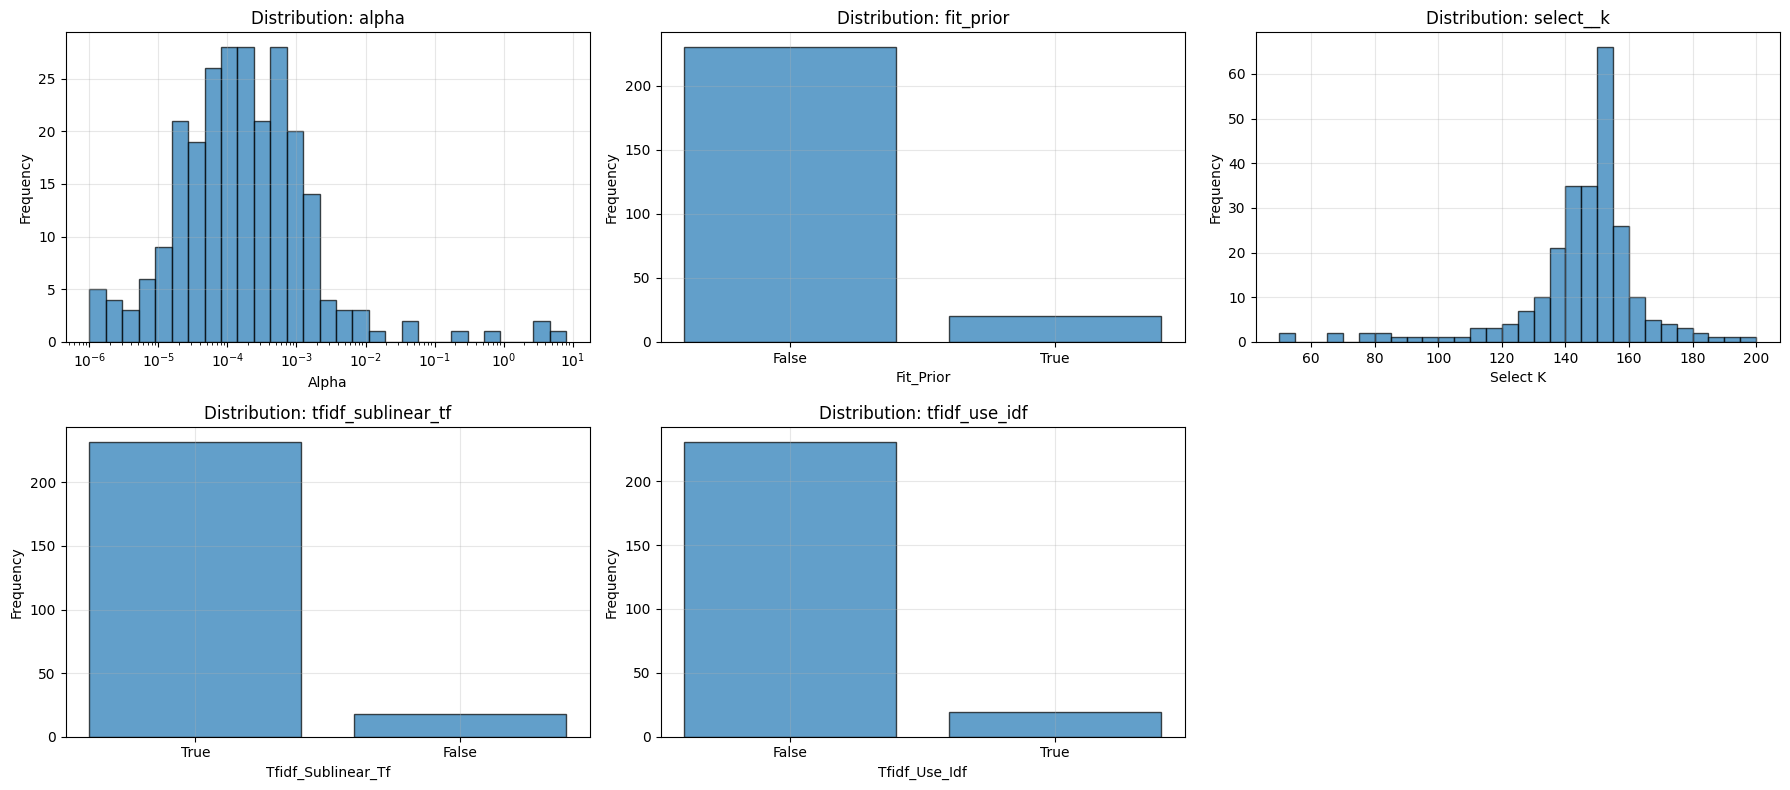


3. Performance vs Individual Parameters:


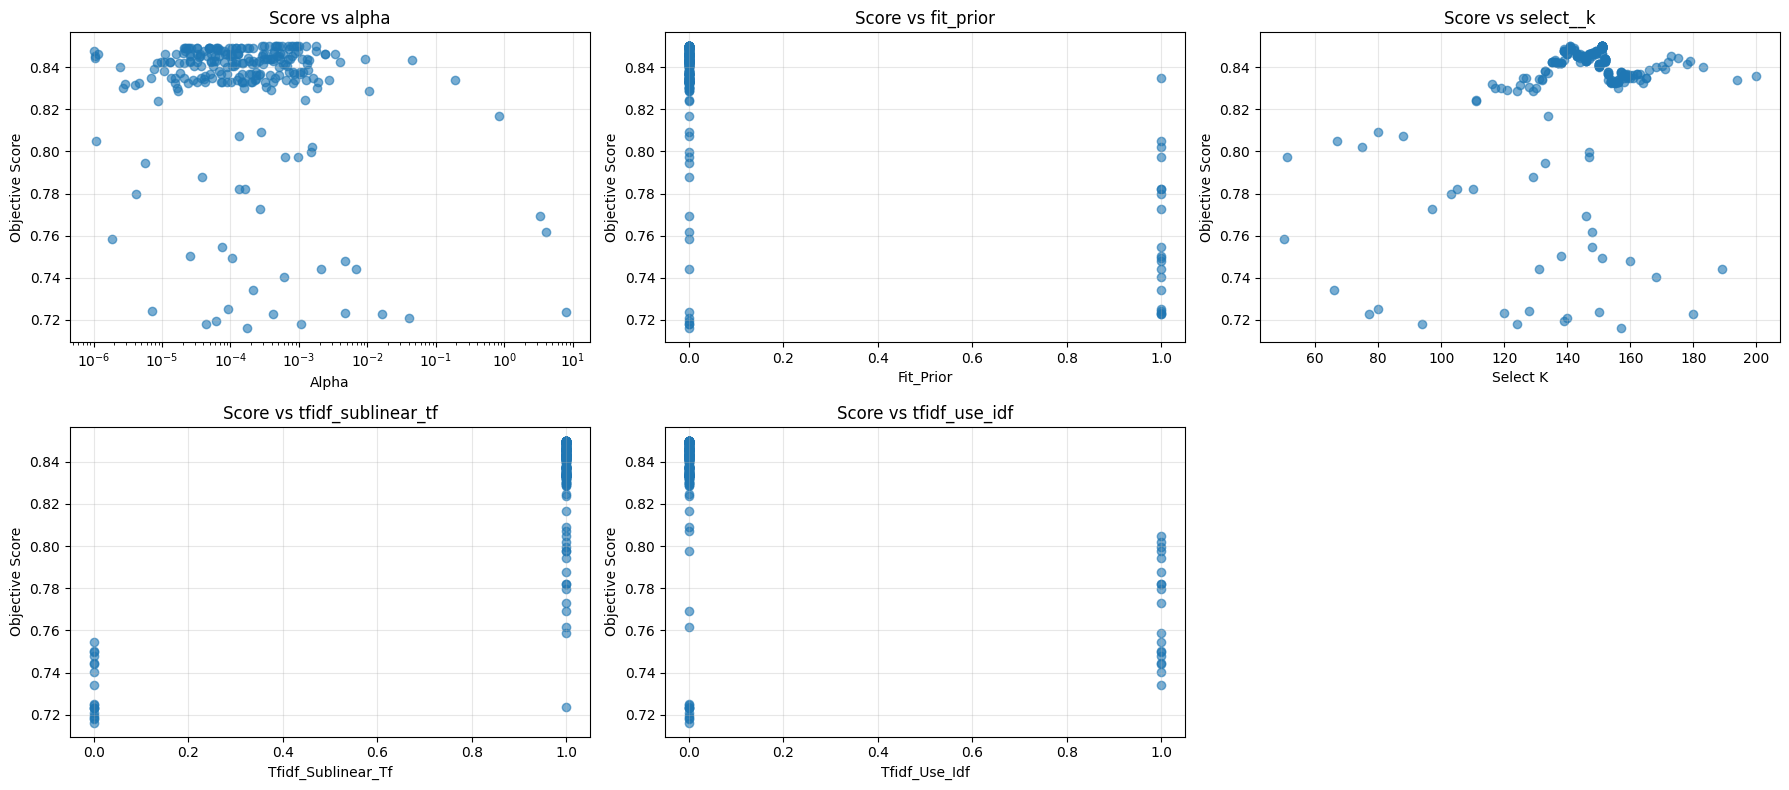


4. Convergence Analysis:


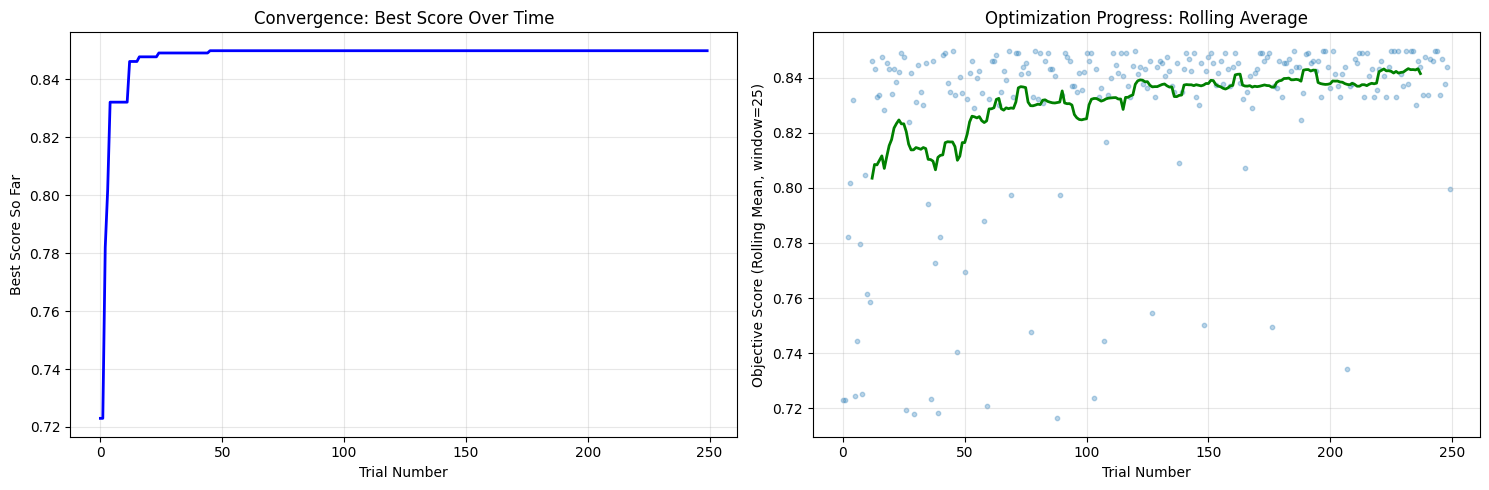


5. Trial Status Overview:


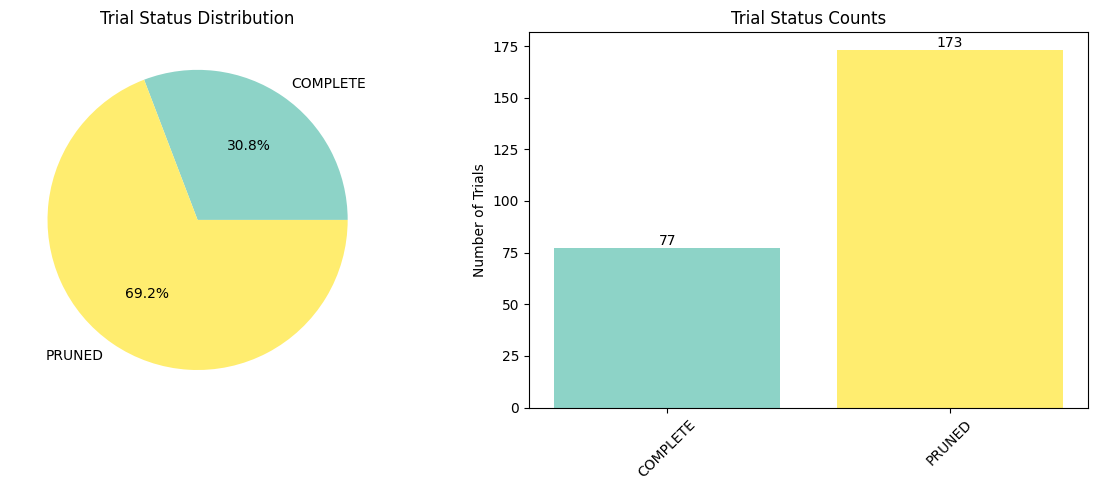


6. Top 10 Best Trials:
Rank Trial#  Score      alpha        fit_prior    k            tfidf_sublinear_tf tfidf_use_idf
-----------------------------------------------------------------------------------------------
1    45      0.8498     0.0006       False        151          True         False       
2    68      0.8498     0.0007       False        151          True         False       
3    120     0.8498     0.0003       False        151          True         False       
4    197     0.8498     0.0004       False        151          True         False       
5    198     0.8498     0.0005       False        151          True         False       
6    201     0.8498     0.0003       False        151          True         False       
7    225     0.8498     0.0005       False        151          True         False       
8    226     0.8498     0.0005       False        151          True         False       
9    228     0.8498     0.0009       False        151          True     

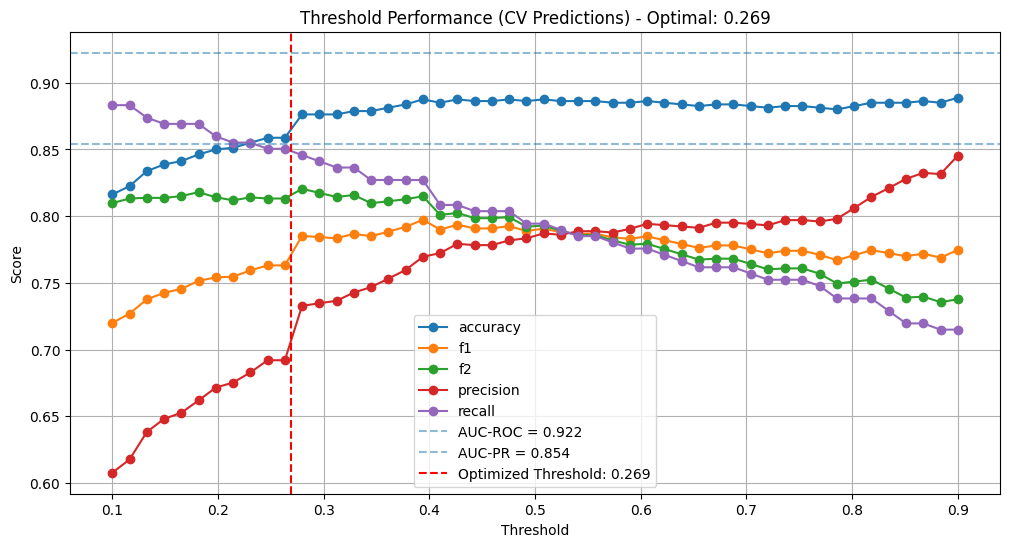

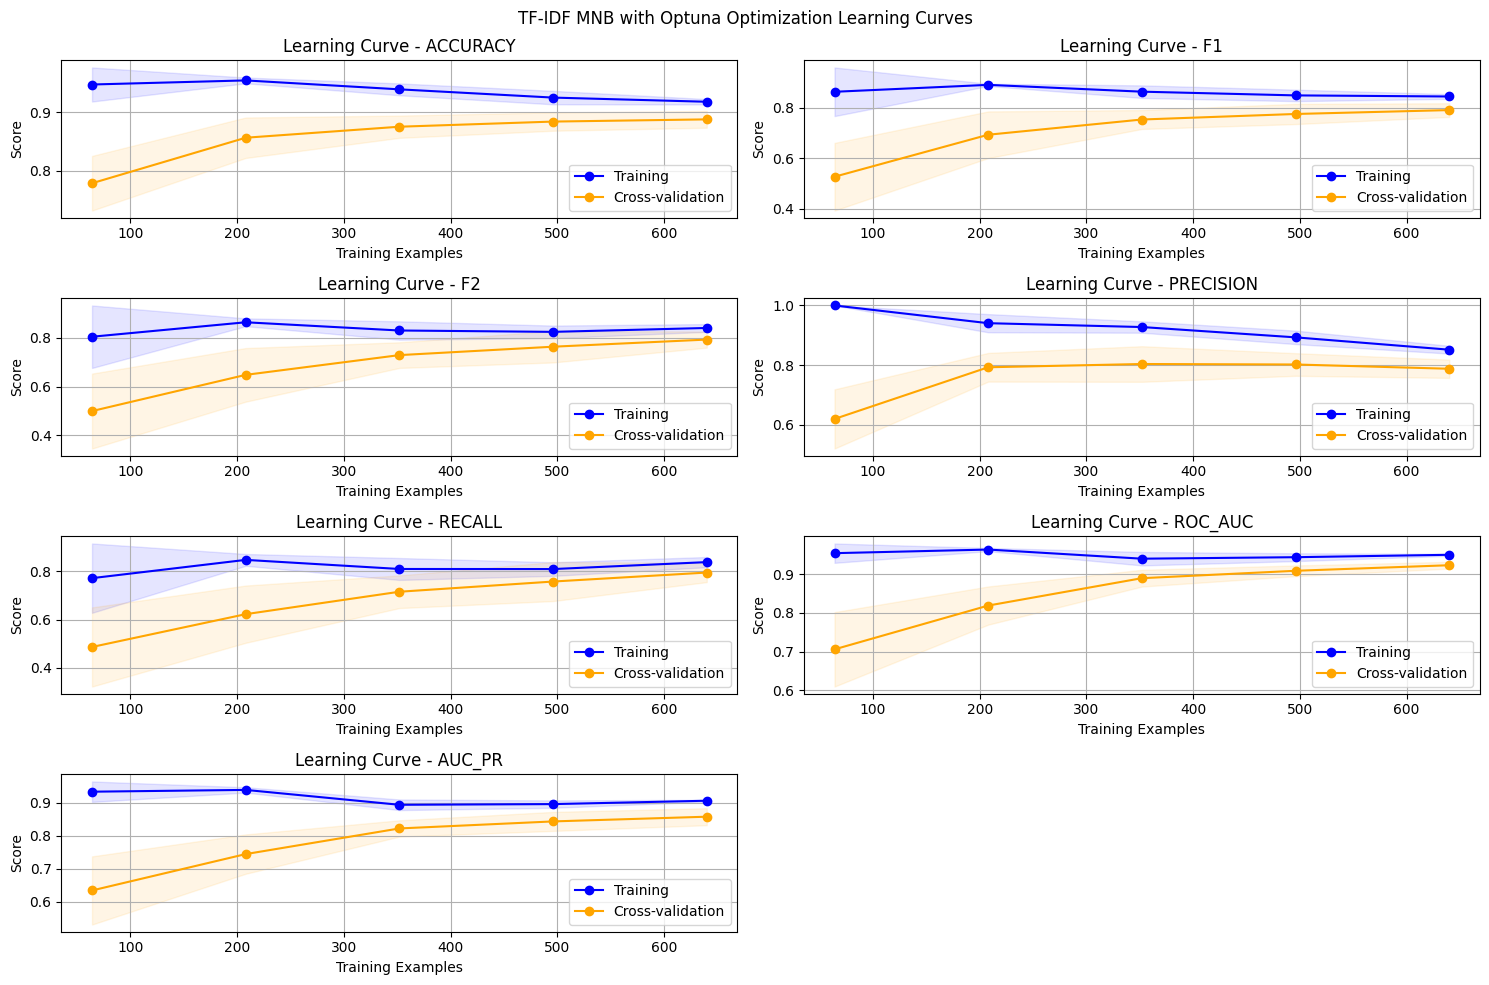


Final Threshold: 0.27

Test Set Performance:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       146
           1       0.69      0.76      0.73        54

    accuracy                           0.84       200
   macro avg       0.80      0.82      0.81       200
weighted avg       0.85      0.84      0.85       200

Additional Metrics:
Accuracy   0.845
F2-score   0.745
AUC-ROC    0.901
AUC-PR     0.812



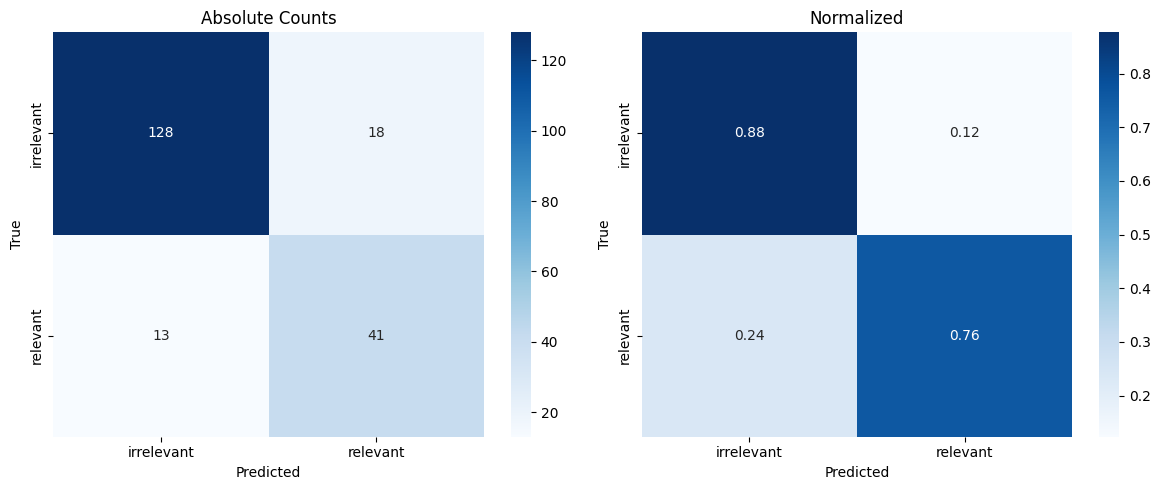

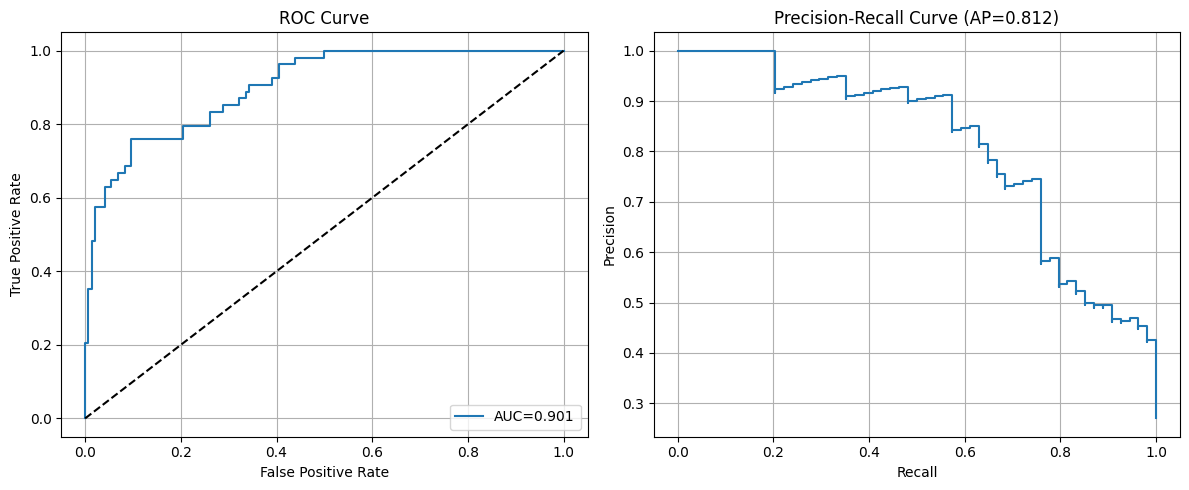


Model saved as 'model_tfidf_mnb_basic.joblib'


In [5]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_basiccleaned["SegmentText"], df_basiccleaned["Label"],
    test_size=0.2,
    stratify=df_basiccleaned["Label"],
    random_state=42
)

# Define a pipeline: TF-IDF vectorization, chi2 feature selection, and a MNB classifier 
pipeline_tfidf_mnb = Pipeline([
    ("tfidf",   TfidfVectorizer(lowercase=True, norm=None, use_idf=False, sublinear_tf=True)), #The multinomial distribution normally requires integer feature counts. sklearn
    ("select",  SelectKBest(score_func=chi2, k=2000)),
    ("clf",     MultinomialNB(
                    alpha=1.0, #will be optimized during optuna
                    fit_prior=True, #will be optimized during optuna    
                ))
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define parameter space for Optuna optimization
param_space = {
    "clf__alpha": lambda trial: trial.suggest_float("alpha", 1e-6, 10.0, log=True),
    "clf__fit_prior": lambda trial: trial.suggest_categorical("fit_prior", [True, False]),
    "tfidf__use_idf":      lambda t: t.suggest_categorical("tfidf_use_idf", [False, True]),
    "tfidf__sublinear_tf": lambda t: t.suggest_categorical("tfidf_sublinear_tf", [False, True]),
    "select__k": lambda trial: trial.suggest_int("select__k", 50, 200)
}

# Execute Optuna optimization with TPE sampler
best_model, best_params, study = optimize_with_optuna(
    estimator=pipeline_tfidf_mnb,
    param_space=param_space,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    n_trials=250,  # Intelligent search with early stopping
    direction="maximize",
    n_jobs=-1,
    random_state=42,
    verbose=False,  # No console output, only file logging
    log_to_file=True,
    model_name="tfidf_mnb_basic"
)

print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10)
)
plt.suptitle('TF-IDF MNB with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1] #predict_proba available for MNB

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1] #predict_proba available for MNB
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': 'TF-IDF + MNB (Basic Preprocessing)',
    'preprocessing_type': 'basic',
    'optimization_method': 'Optuna TPE + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, "model_tfidf_mnb_basic.joblib")

print(f"\nModel saved as 'model_tfidf_mnb_basic.joblib'")

CNB --> no real advantages, so imbalance not that big of a problem here. CNB specifically for imbalanced data

Best parameters found by Optuna TPE: {'alpha': 0.000859805147197019, 'fit_prior': False, 'tfidf_use_idf': False, 'tfidf_sublinear_tf': True, 'select__k': 151}
Best F2 score during optimization: 0.850

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


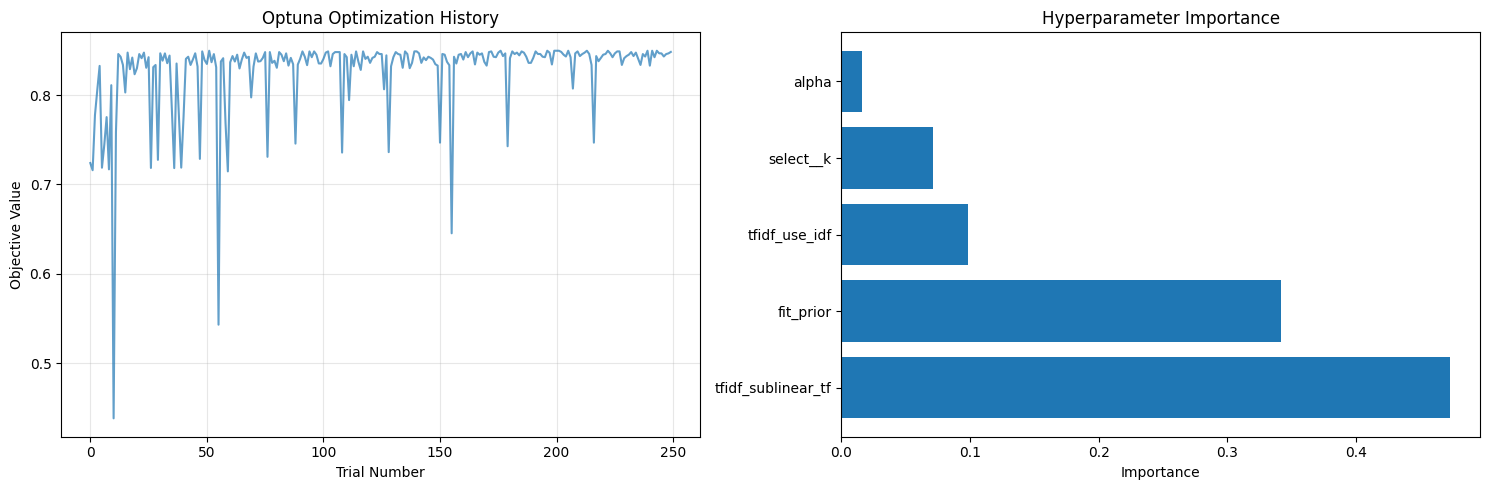


2. Parameter Value Distributions:


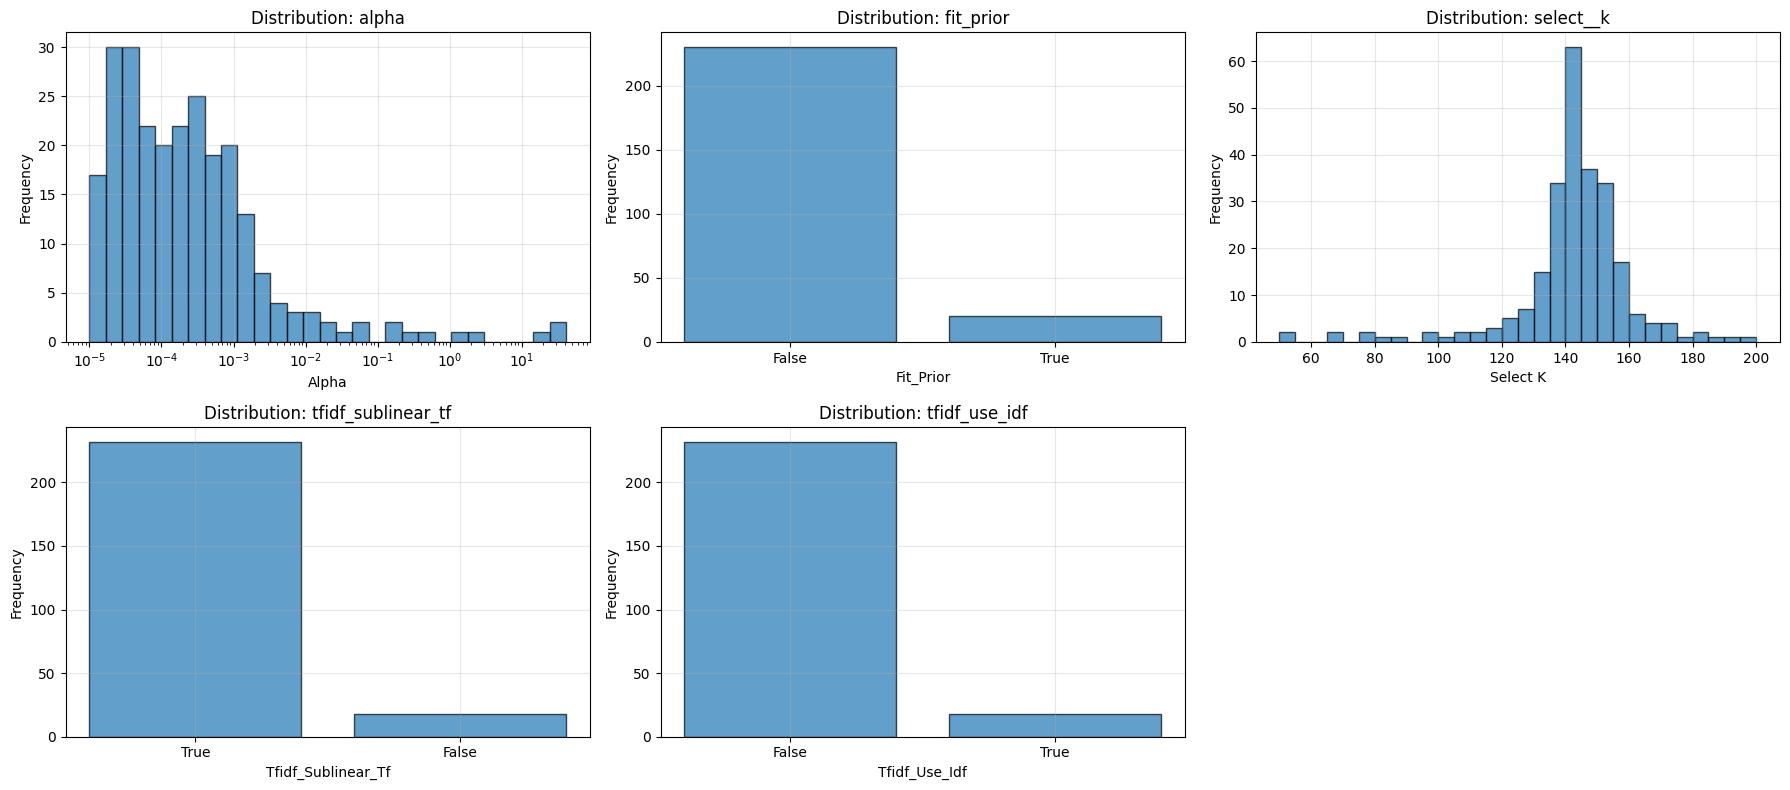


3. Performance vs Individual Parameters:


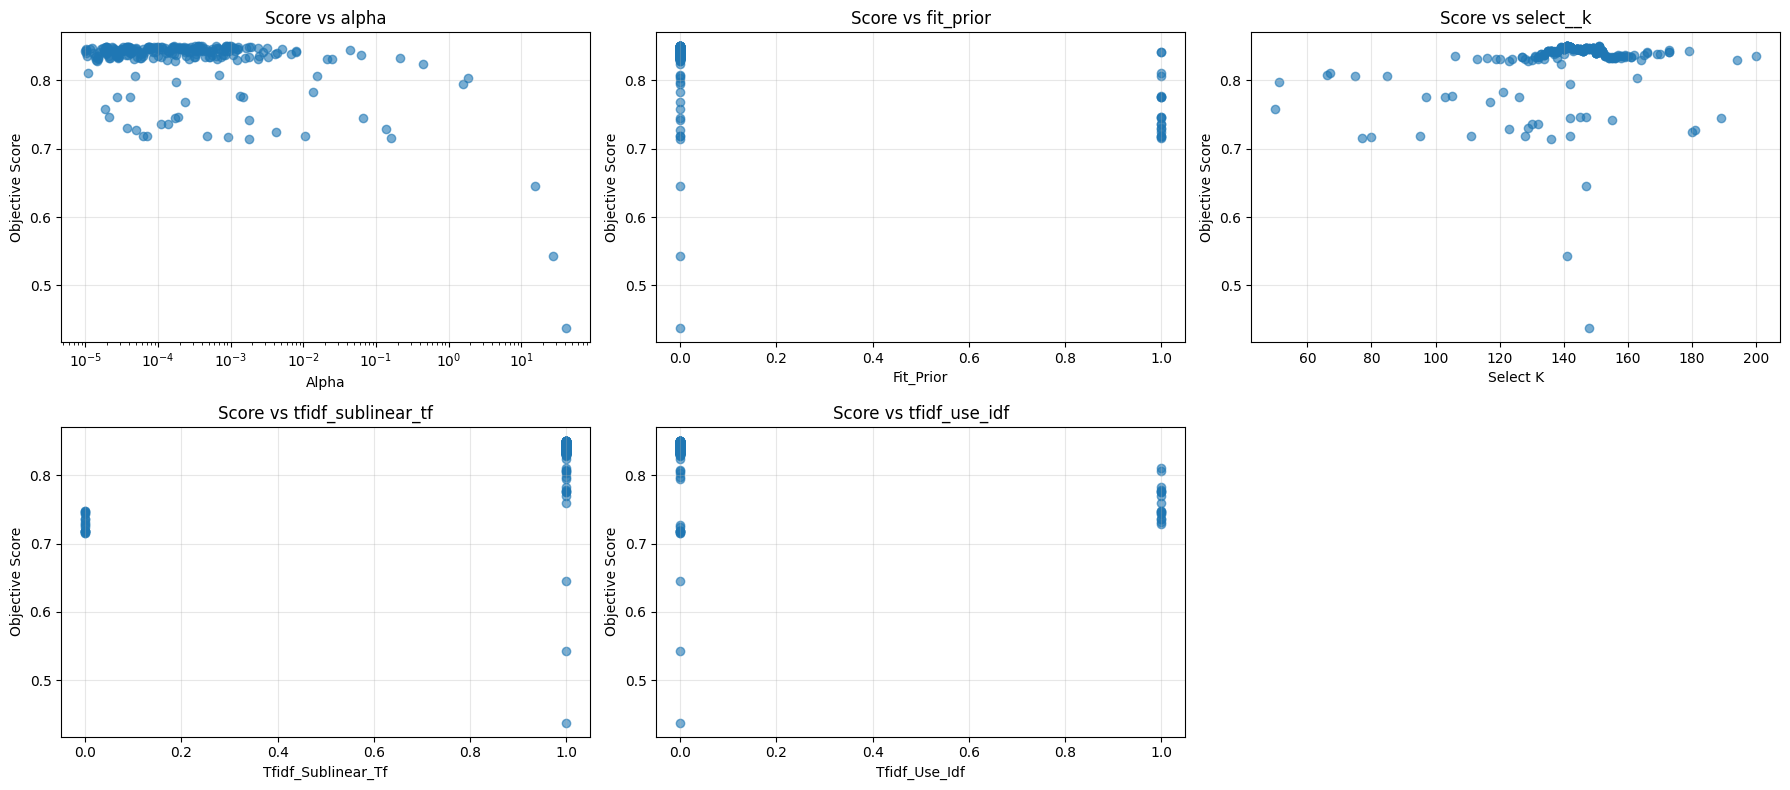


4. Convergence Analysis:


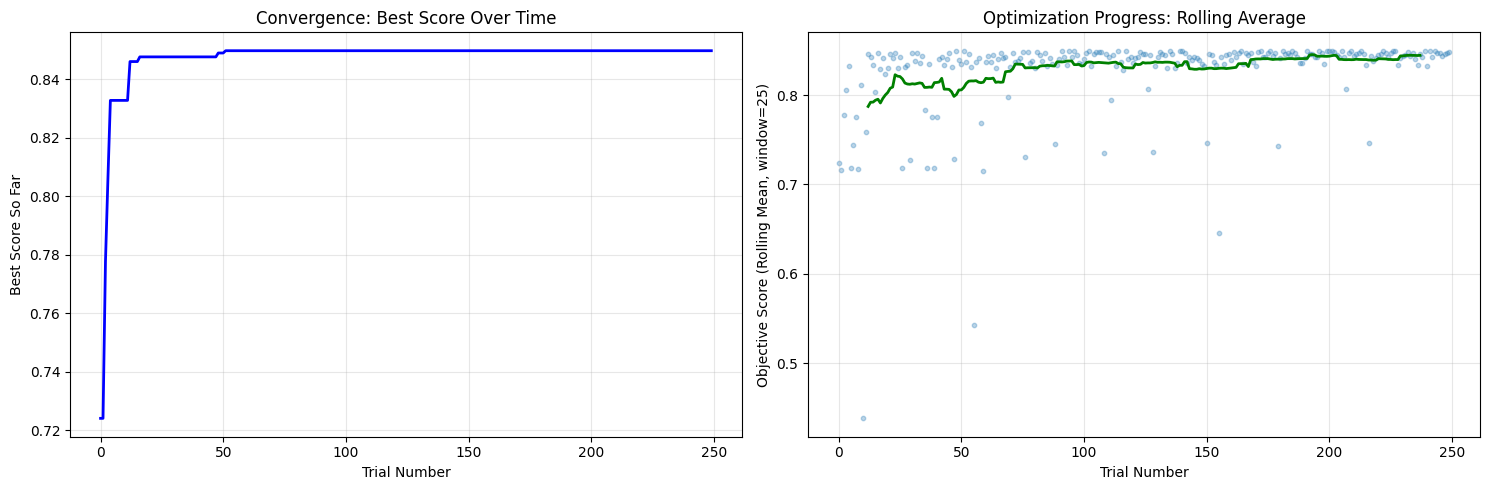


5. Trial Status Overview:


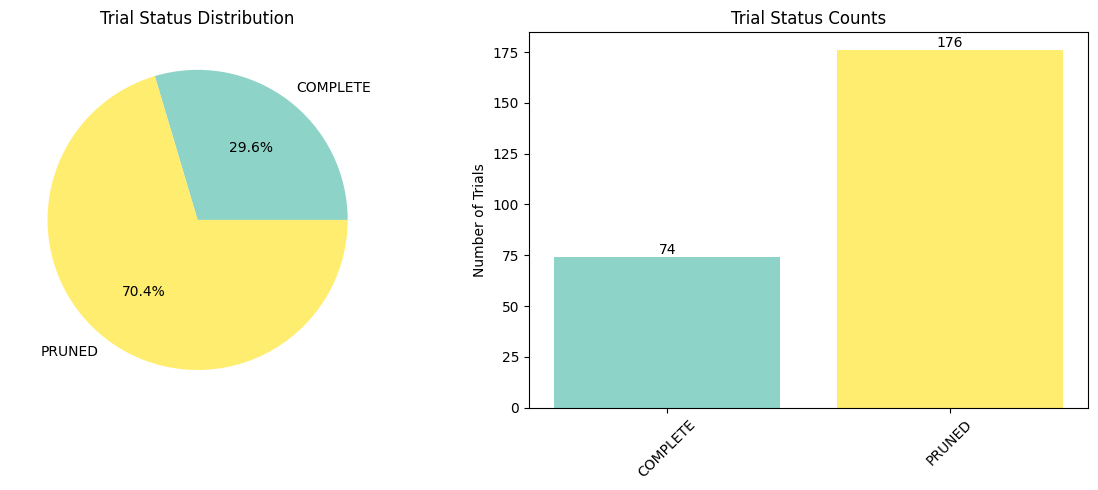


6. Top 10 Best Trials:
Rank Trial#  Score      alpha        fit_prior    k            tfidf_sublinear_tf tfidf_use_idf
-----------------------------------------------------------------------------------------------
1    51      0.8498     0.0009       False        151          True         False       
2    176     0.8498     0.0006       False        151          True         False       
3    196     0.8498     0.0004       False        141          True         False       
4    199     0.8498     0.0004       False        141          True         False       
5    200     0.8498     0.0004       False        141          True         False       
6    201     0.8498     0.0003       False        141          True         False       
7    205     0.8498     0.0004       False        141          True         False       
8    213     0.8498     0.0002       False        141          True         False       
9    222     0.8498     0.0009       False        141          True     

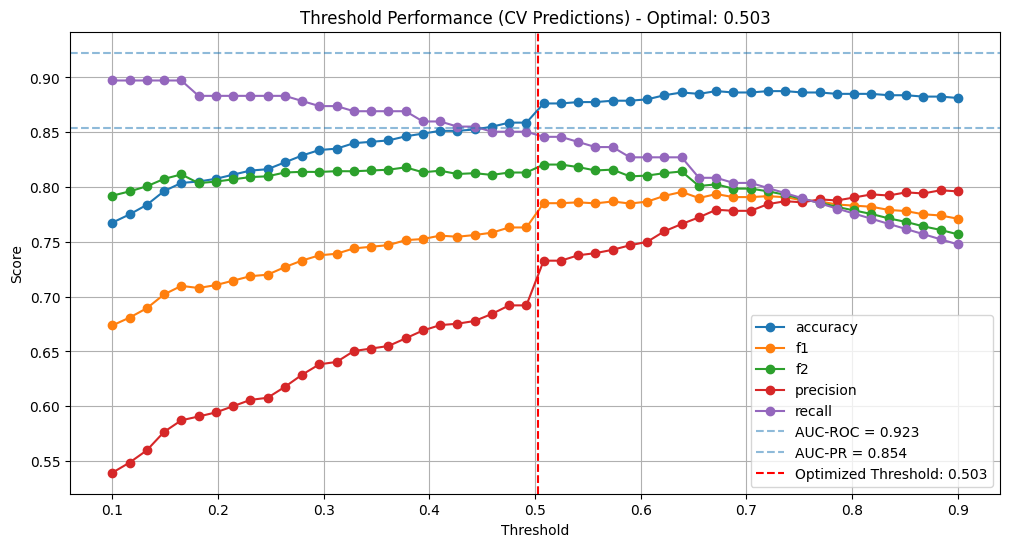

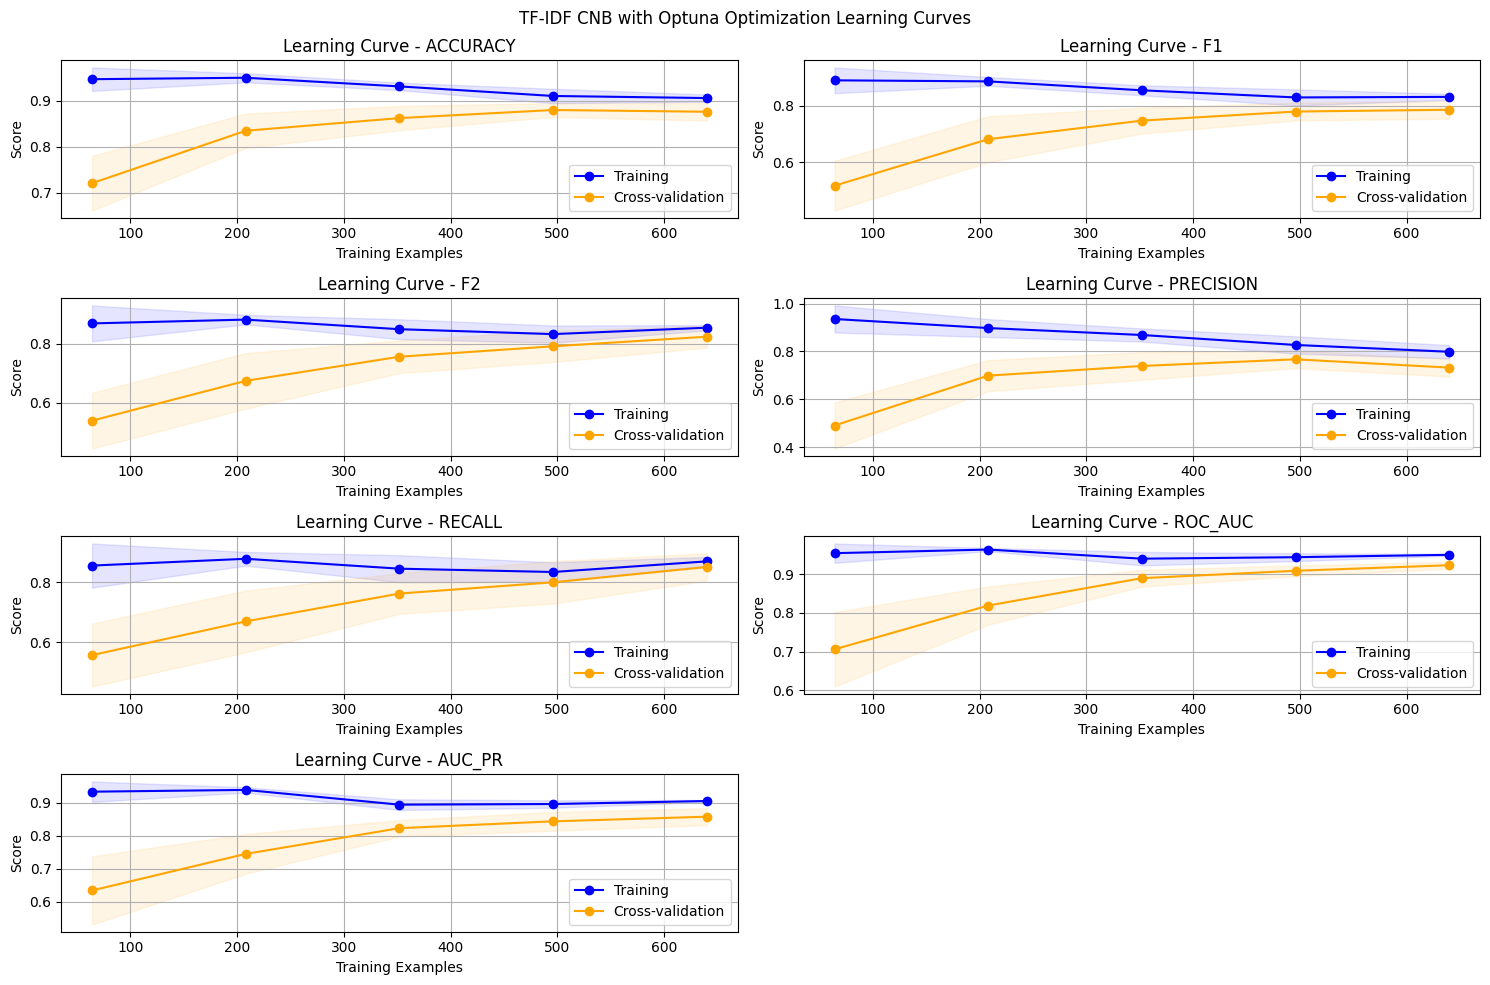


Final Threshold: 0.50

Test Set Performance:
              precision    recall  f1-score   support

           0       0.91      0.88      0.89       146
           1       0.69      0.76      0.73        54

    accuracy                           0.84       200
   macro avg       0.80      0.82      0.81       200
weighted avg       0.85      0.84      0.85       200

Additional Metrics:
Accuracy   0.845
F2-score   0.745
AUC-ROC    0.901
AUC-PR     0.812



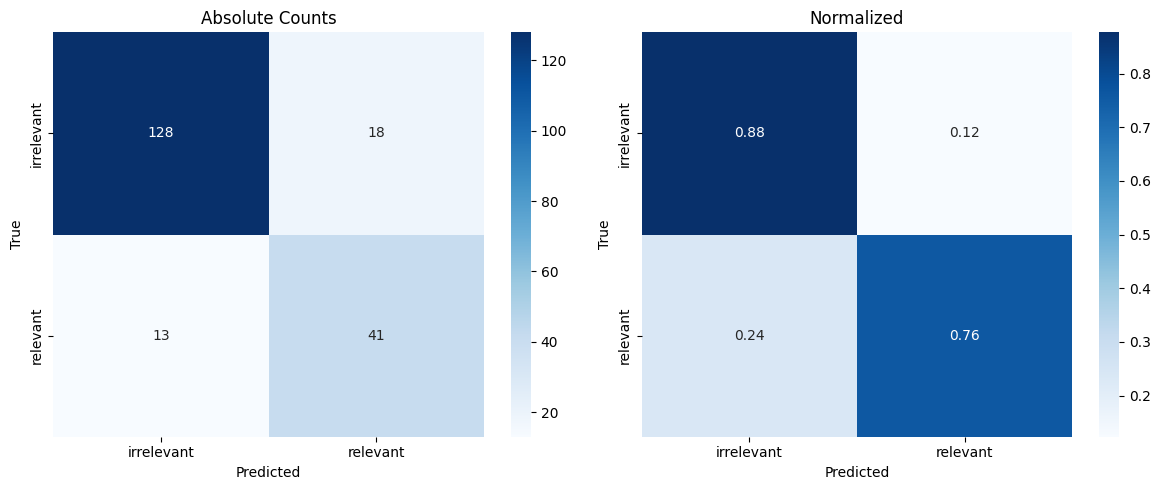

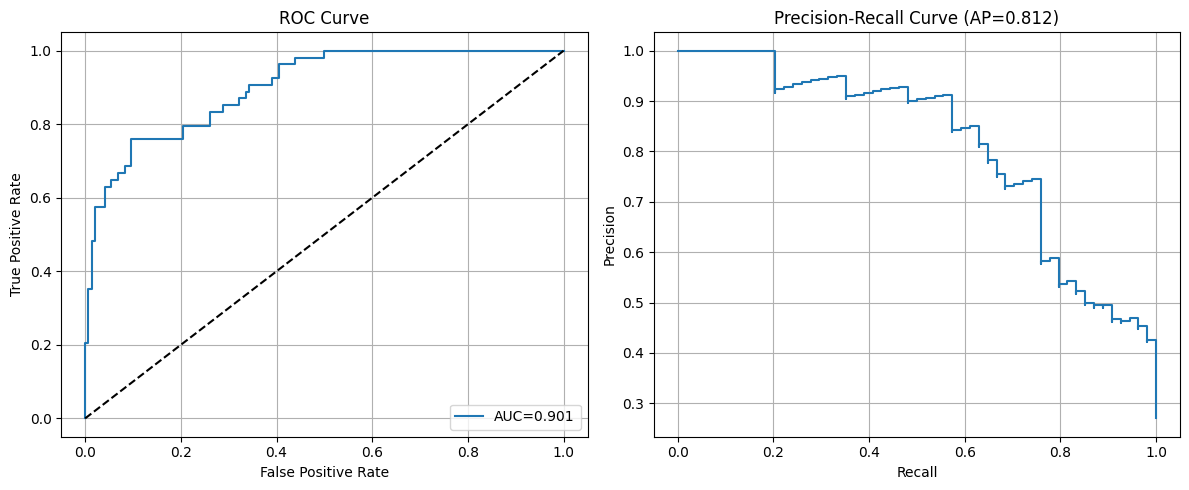


Model saved as 'model_tfidf_cnb_basic.joblib'


In [7]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_basiccleaned["SegmentText"], df_basiccleaned["Label"],
    test_size=0.2,
    stratify=df_basiccleaned["Label"],
    random_state=42
)

# Define a pipeline: TF-IDF vectorization, chi2 feature selection, and a MNB classifier 
pipeline_tfidf_cnb = Pipeline([
    ("tfidf",   TfidfVectorizer(lowercase=True, norm=None, use_idf=False, sublinear_tf=True)), #The multinomial distribution normally requires integer feature counts. sklearn
    ("select",  SelectKBest(score_func=chi2, k=2000)),
    ("clf",     ComplementNB(
                    alpha=1.0, #will be optimized during optuna
                    fit_prior=True, #will be optimized during optuna
                    norm=False #will be optimized during optuna   
                ))
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define parameter space for Optuna optimization
param_space = {
    "clf__alpha": lambda trial: trial.suggest_float("alpha", 1e-5, 1e+2, log=True),
    "clf__fit_prior": lambda trial: trial.suggest_categorical("fit_prior", [True, False]),
    "tfidf__use_idf":      lambda t: t.suggest_categorical("tfidf_use_idf", [False, True]),
    "tfidf__sublinear_tf": lambda t: t.suggest_categorical("tfidf_sublinear_tf", [False, True]),
    "select__k": lambda trial: trial.suggest_int("select__k", 50, 200) #widened after first runs and visuals from 50 to 150 to 1 to 150
}

# Execute Optuna optimization with TPE sampler
best_model, best_params, study = optimize_with_optuna(
    estimator=pipeline_tfidf_cnb,
    param_space=param_space,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    n_trials=250,  # Intelligent search with early stopping
    direction="maximize",
    n_jobs=-1,
    random_state=42,
    verbose=False,  # No console output, only file logging
    log_to_file=True,
    model_name="tfidf_cnb_basic"
)

print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10)
)
plt.suptitle('TF-IDF CNB with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1] #predict_proba available for NB

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1] #predict_proba available for NB
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': 'TF-IDF + CNB (Basic Preprocessing)',
    'preprocessing_type': 'basic',
    'optimization_method': 'Optuna TPE + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, "model_tfidf_cnb_basic.joblib")

print(f"\nModel saved as 'model_tfidf_cnb_basic.joblib'")

**a) MNB + CNB advanced preprocessed data**

In [11]:
# Load and preprocess data (advanced mode)
df_advancedcleaned = process_file(
    filepath='../05modeling_pipelines/1klabeled_segments.csv',
    file_format='csv',
    text_key='SegmentText', 
    mode='advanced'  # advanced cleaning mode
)

# Map labels to binary values
df_advancedcleaned['Label'] = df_advancedcleaned['Label'].map({"['relevant']": 1, "['irrelevant']": 0})

MNB

Best parameters found by Optuna TPE: {'alpha': 4.69967082461246e-06, 'fit_prior': True, 'select__k': 179, 'tfidf_use_idf': False, 'tfidf_sublinear_tf': True, 'phrases__enable': False, 'phrases__min_count': 8, 'phrases__threshold': 220.10285798456792}
Best F2 score during optimization: 0.855

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


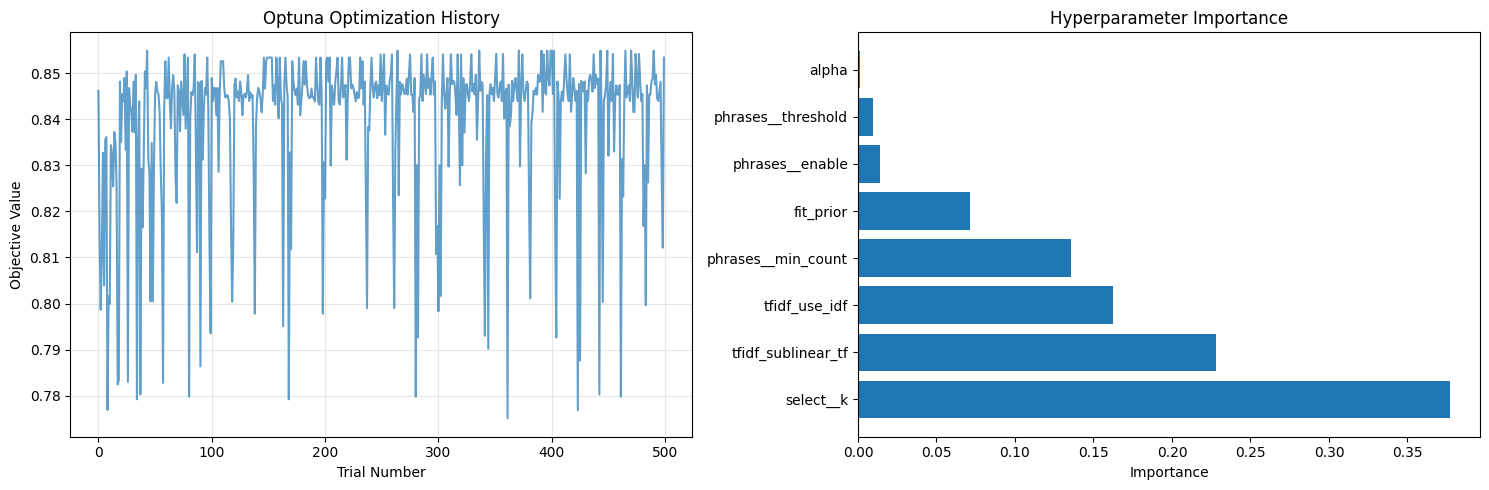


2. Parameter Value Distributions:


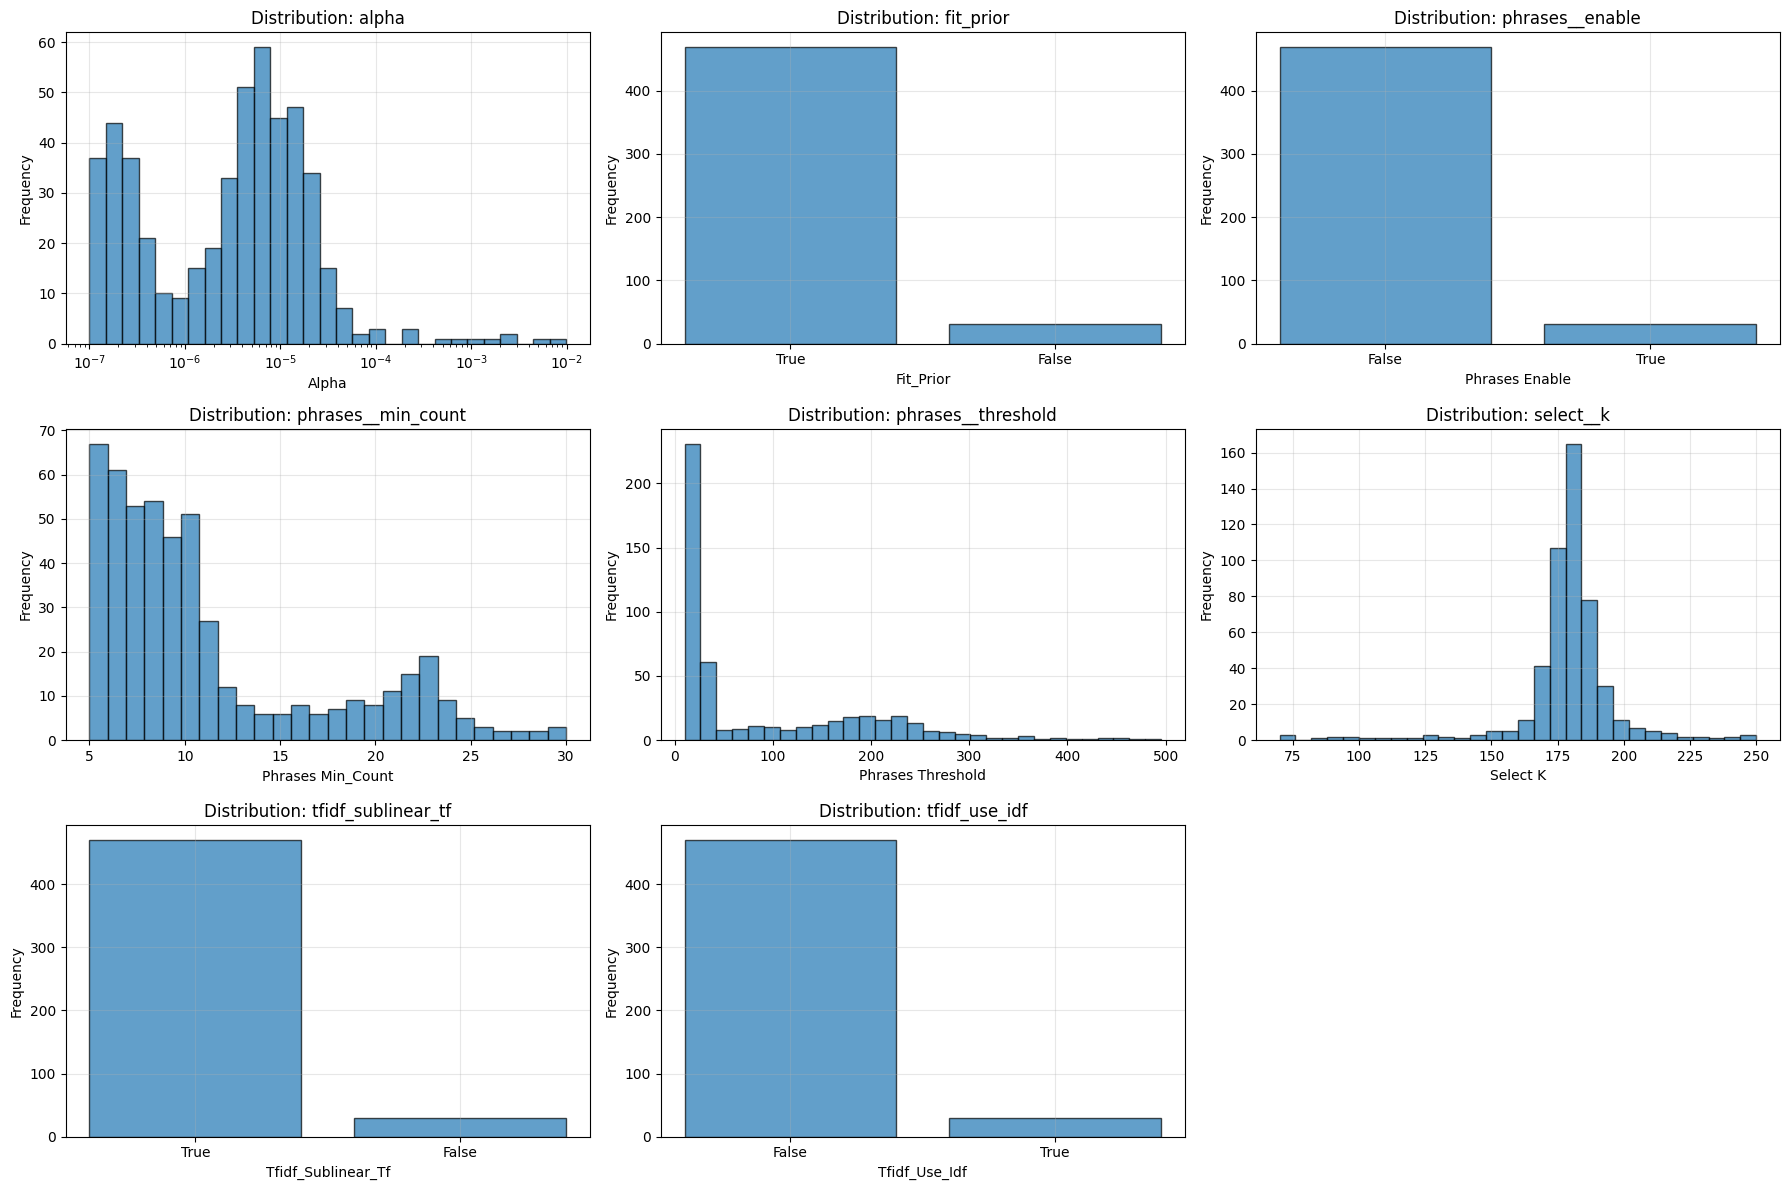


3. Performance vs Individual Parameters:


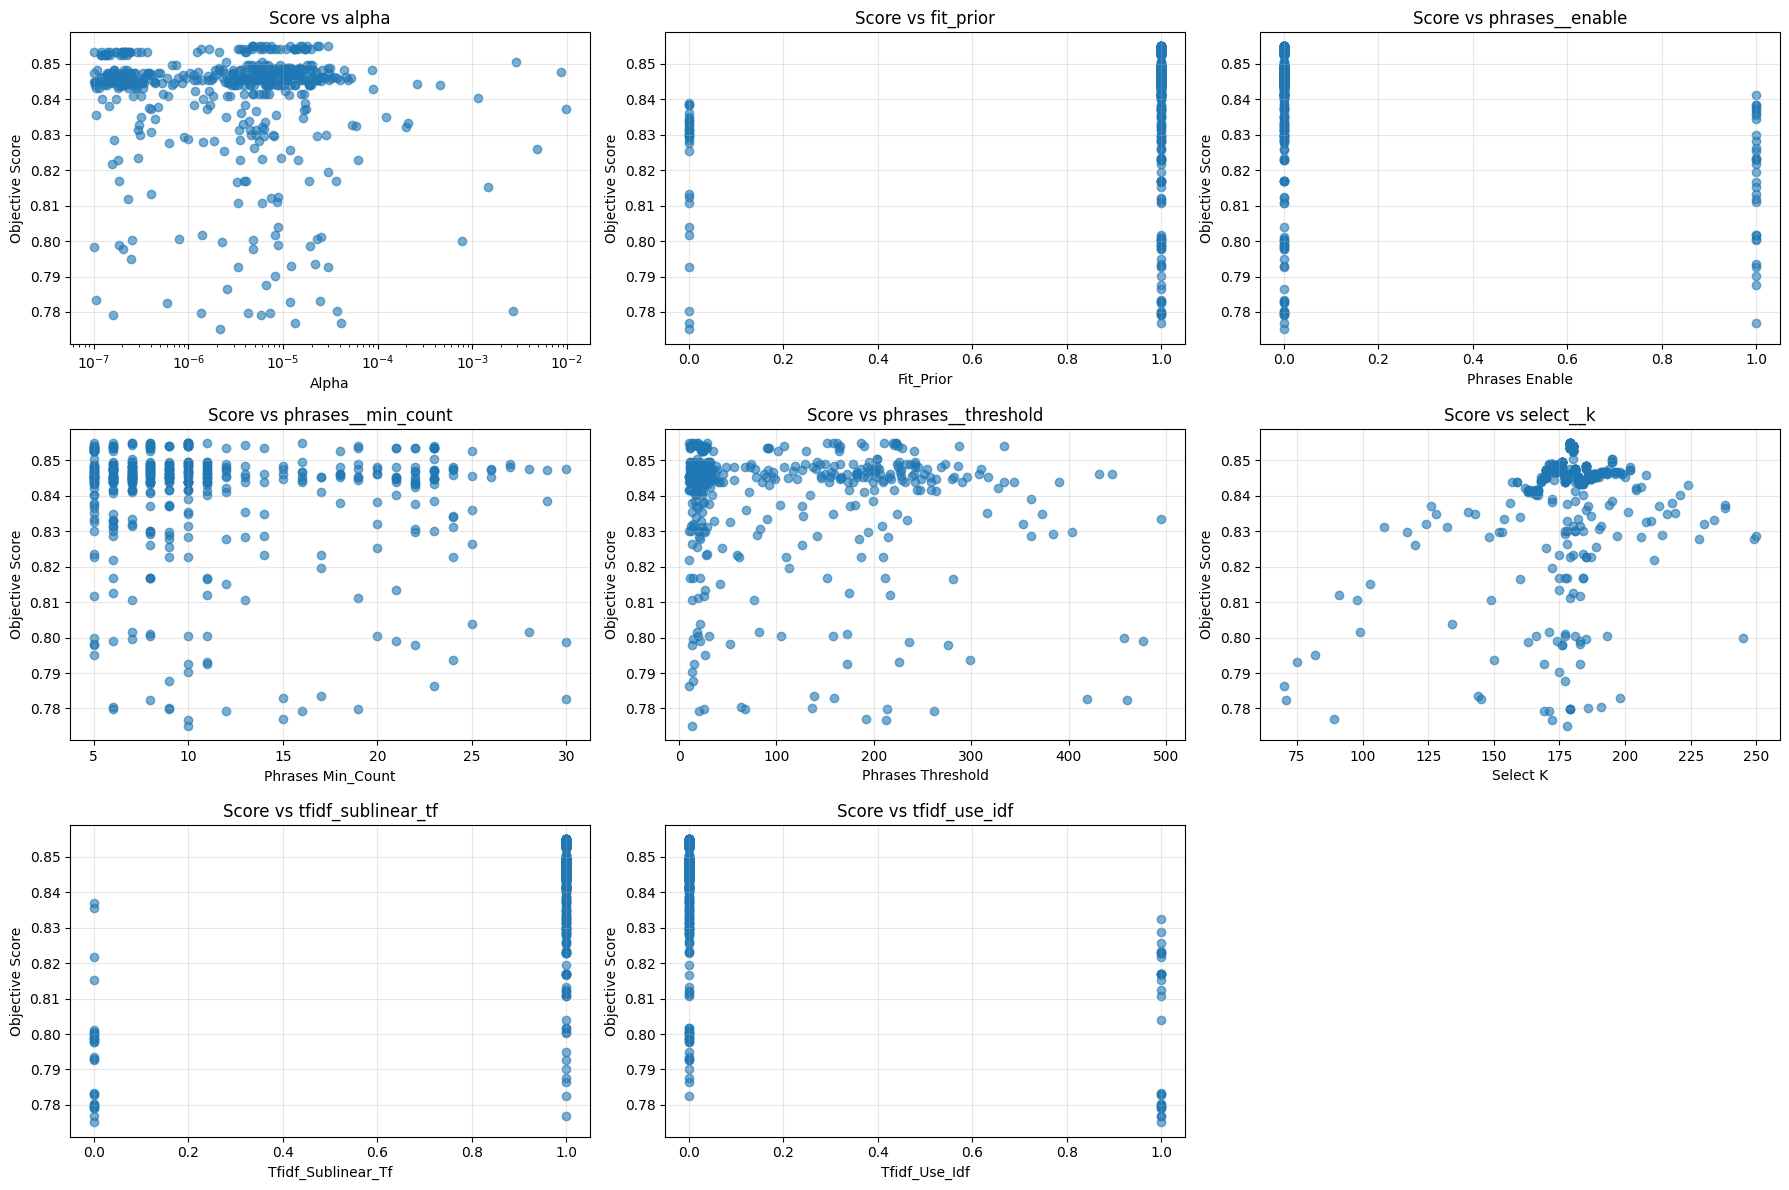


4. Convergence Analysis:


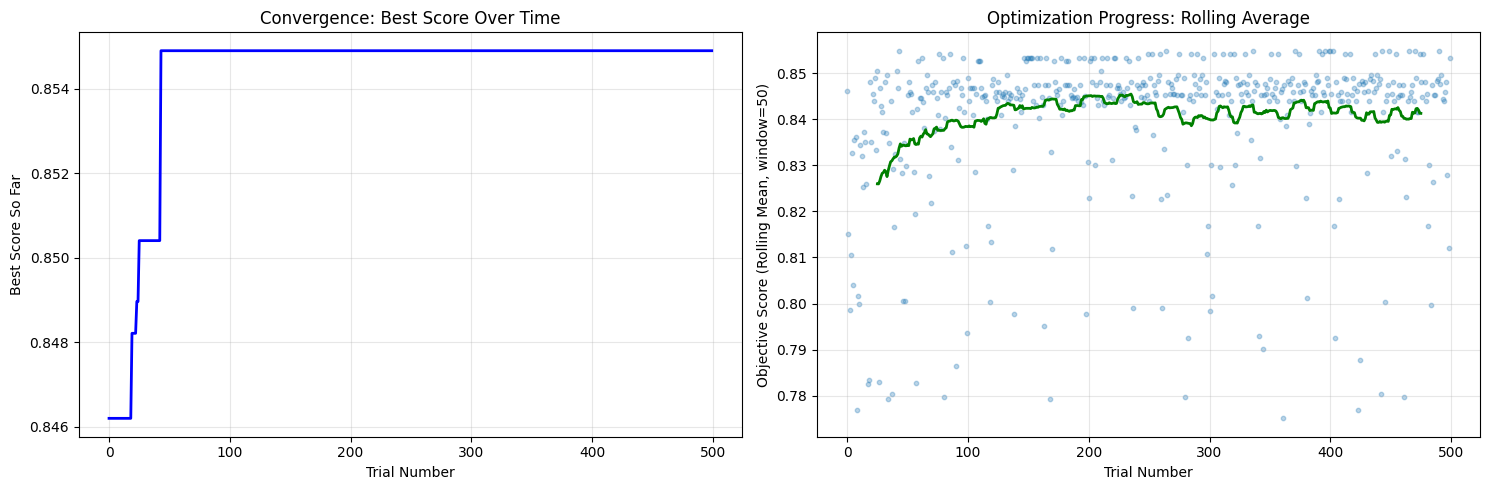


5. Trial Status Overview:


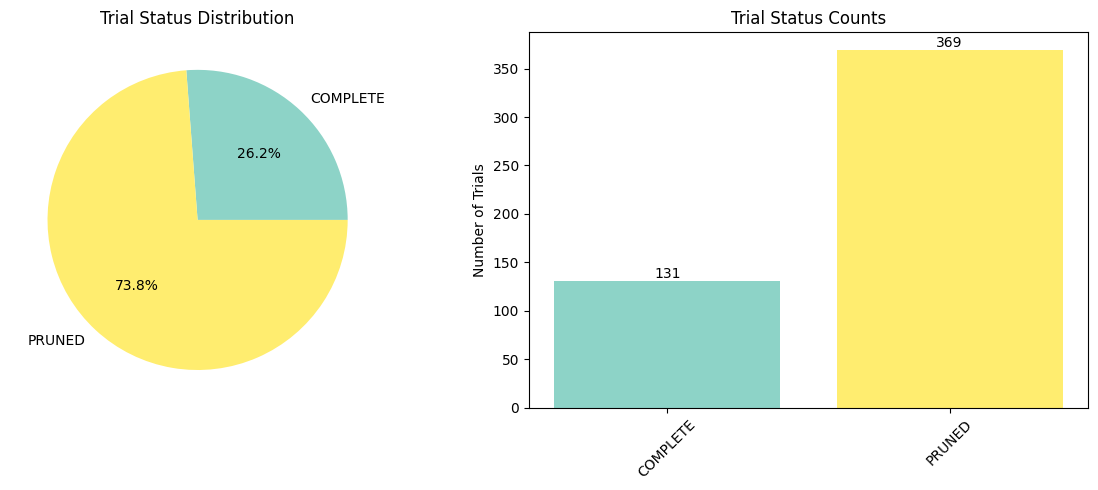


6. Top 10 Best Trials:
Rank Trial#  Score      alpha        fit_prior    enable       min_count    threshold    k            tfidf_sublinear_tf tfidf_use_idf
--------------------------------------------------------------------------------------------------------------------------------------
1    43      0.8549     0.0000       True         False        8            220.1029     179          True         False       
2    264     0.8549     0.0000       True         False        5            28.3212      179          True         False       
3    336     0.8549     0.0000       True         False        11           14.5165      179          True         False       
4    371     0.8549     0.0000       True         False        8            210.6007     179          True         False       
5    391     0.8549     0.0000       True         False        10           186.6536     179          True         False       
6    396     0.8549     0.0000       True         False        10 

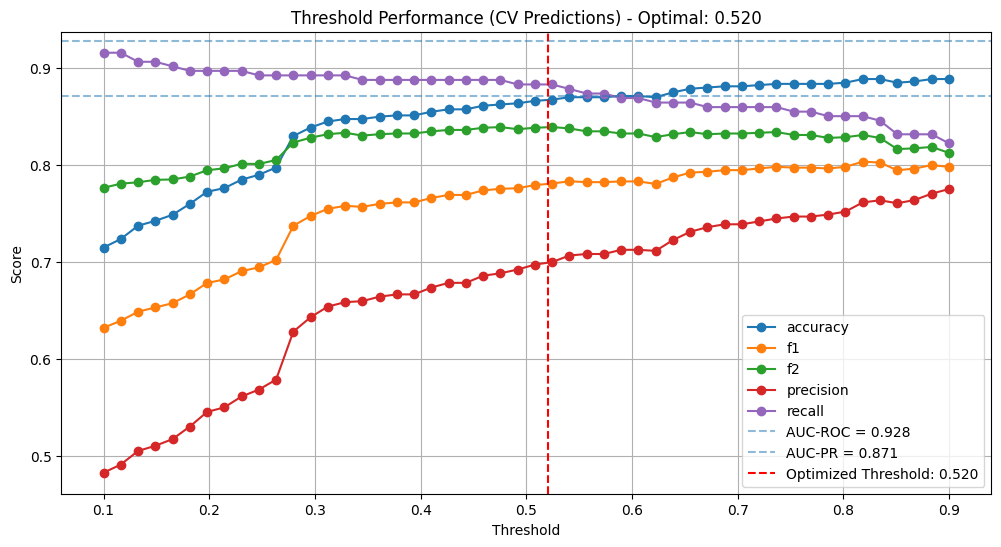

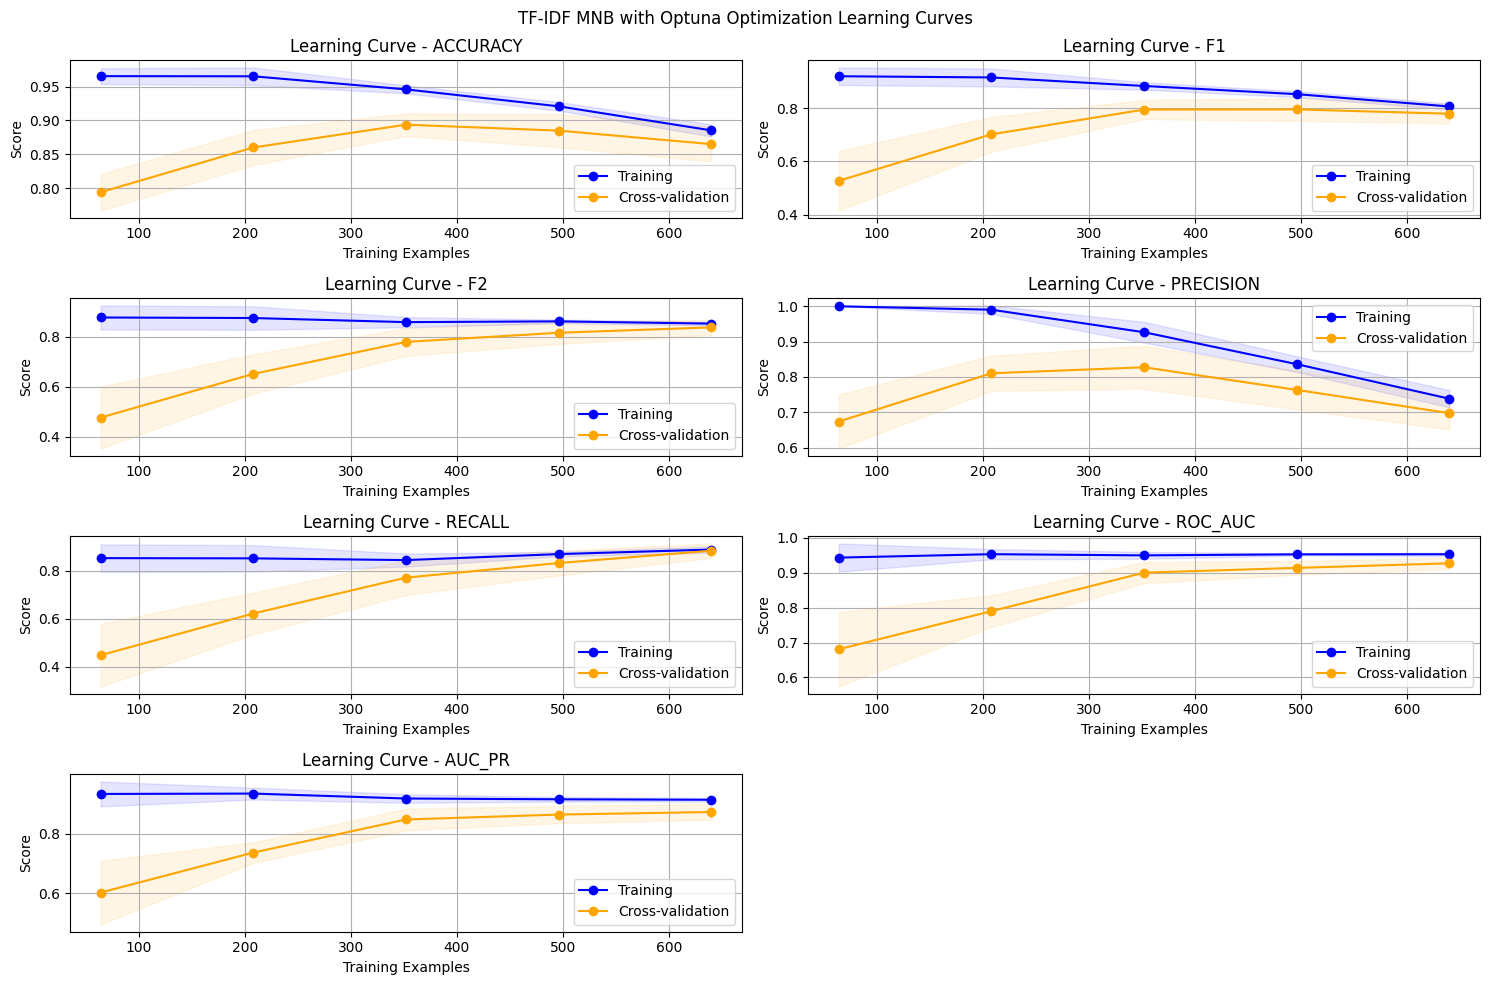


Final Threshold: 0.52

Test Set Performance:
              precision    recall  f1-score   support

           0       0.96      0.87      0.91       146
           1       0.72      0.91      0.80        54

    accuracy                           0.88       200
   macro avg       0.84      0.89      0.86       200
weighted avg       0.90      0.88      0.88       200

Additional Metrics:
Accuracy   0.880
F2-score   0.863
AUC-ROC    0.931
AUC-PR     0.870



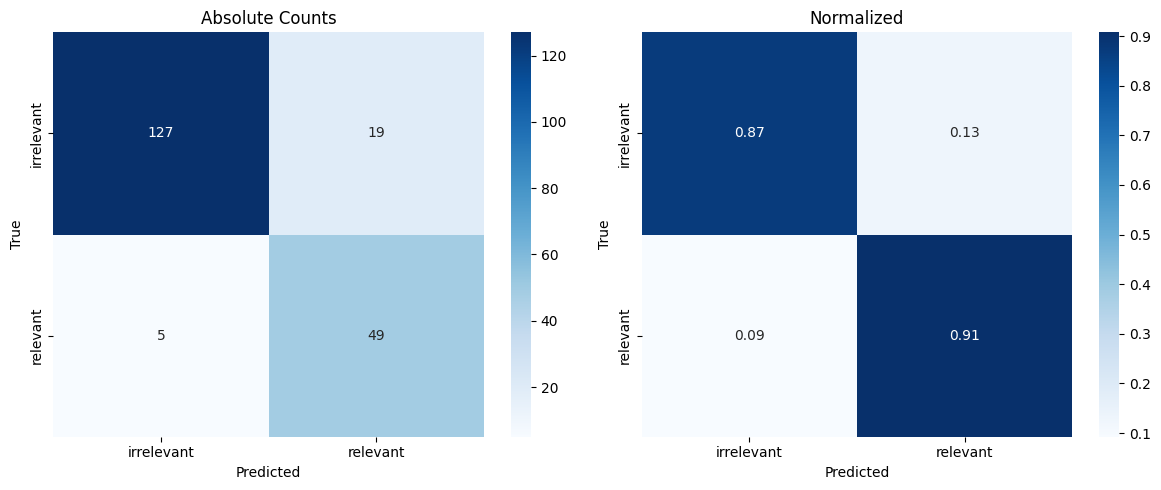

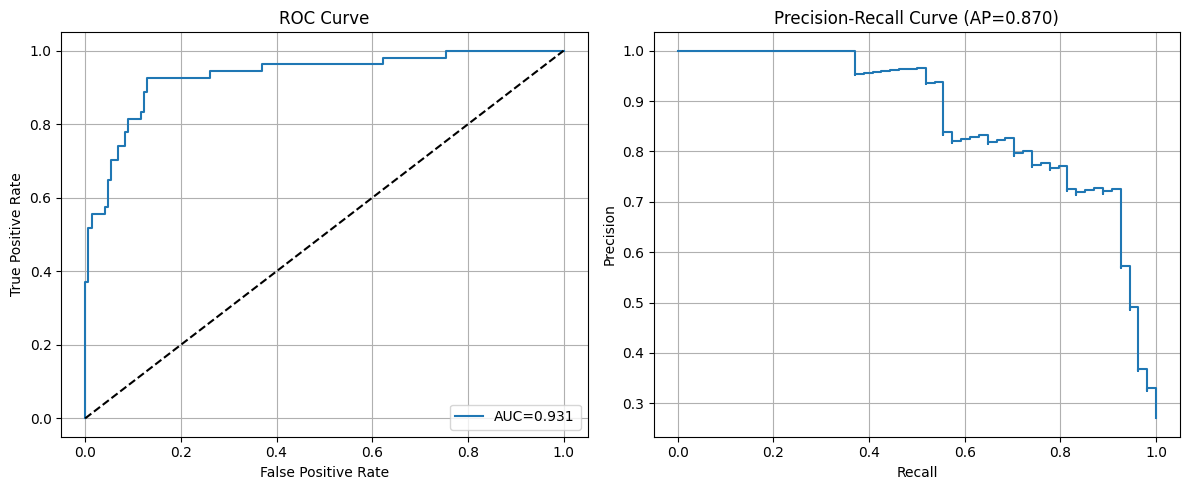


Model saved as 'model_tfidf_mnb_advanced.joblib'


In [14]:
#perform train-test split
# Holdout-Split (80% training, 20% final test)
X_dev, X_test, y_dev, y_test = train_test_split(
    df_advancedcleaned["SegmentText"], df_advancedcleaned["Label"],
    test_size=0.2,
    stratify=df_advancedcleaned["Label"],
    random_state=42
)

# Define a pipeline: TF-IDF vectorization, chi2 feature selection, and a MNB classifier 
pipeline_tfidf_mnb = Pipeline([
    ("phrases", PhraseDetector(enable=True, min_count=10, threshold=300.0)),
    ("tfidf",   TfidfVectorizer(lowercase=True, norm=None, use_idf=False, sublinear_tf=True)), #The multinomial distribution normally requires integer feature counts. sklearn
    ("select",  SelectKBest(score_func=chi2, k=2000)),
    ("clf",     MultinomialNB(
                    alpha=1.0, #will be optimized during optuna
                    fit_prior=True, #will be optimized during optuna    
                ))
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define parameter space for Optuna optimization
param_space = {
    "clf__alpha": lambda trial: trial.suggest_float("alpha", 1e-7, 1e-2, log=True),
    "clf__fit_prior": lambda trial: trial.suggest_categorical("fit_prior", [True, False]),
    "select__k": lambda trial: trial.suggest_int("select__k", 70, 250),
    "tfidf__use_idf":      lambda t: t.suggest_categorical("tfidf_use_idf", [False, True]),
    "tfidf__sublinear_tf": lambda t: t.suggest_categorical("tfidf_sublinear_tf", [False, True]),
    "phrases__enable":      lambda t: t.suggest_categorical("phrases__enable", [True, False]),
    "phrases__min_count":   lambda t: t.suggest_int("phrases__min_count", 5, 30),
    "phrases__threshold":   lambda t: t.suggest_float("phrases__threshold", 10.0, 500.0, log=True)
}

# Execute Optuna optimization with TPE sampler
best_model, best_params, study = optimize_with_optuna(
    estimator=pipeline_tfidf_mnb,
    param_space=param_space,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    n_trials=500,  # Intelligent search with early stopping
    direction="maximize",
    n_jobs=-1,
    random_state=42,
    verbose=False,  # No console output, only file logging
    log_to_file=True,
    model_name="tfidf_mnb_advanced"
)

print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10)
)
plt.suptitle('TF-IDF MNB with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1] #predict_proba available for MNB

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1] #predict_proba available for MNB
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': 'TF-IDF + MNB',
    'preprocessing_type': 'advanced',
    'optimization_method': 'Optuna TPE + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, "model_tfidf_mnb_advanced.joblib")

print(f"\nModel saved as 'model_tfidf_mnb_advanced.joblib'")

CNB --> also on advanced data no real improvement, imbalance doesn´t seem to be that big of a problem

Best parameters found by Optuna TPE: {'alpha': 0.0003424150872746573, 'fit_prior': True, 'norm': False, 'select__k': 194, 'tfidf_use_idf': False, 'tfidf_sublinear_tf': True, 'phrases__enable': True, 'phrases__min_count': 24, 'phrases__threshold': 31.736593798716736}
Best F2 score during optimization: 0.853

COMPREHENSIVE OPTUNA STUDY ANALYSIS & VISUALIZATIONS

1. Optimization History & Parameter Importance:


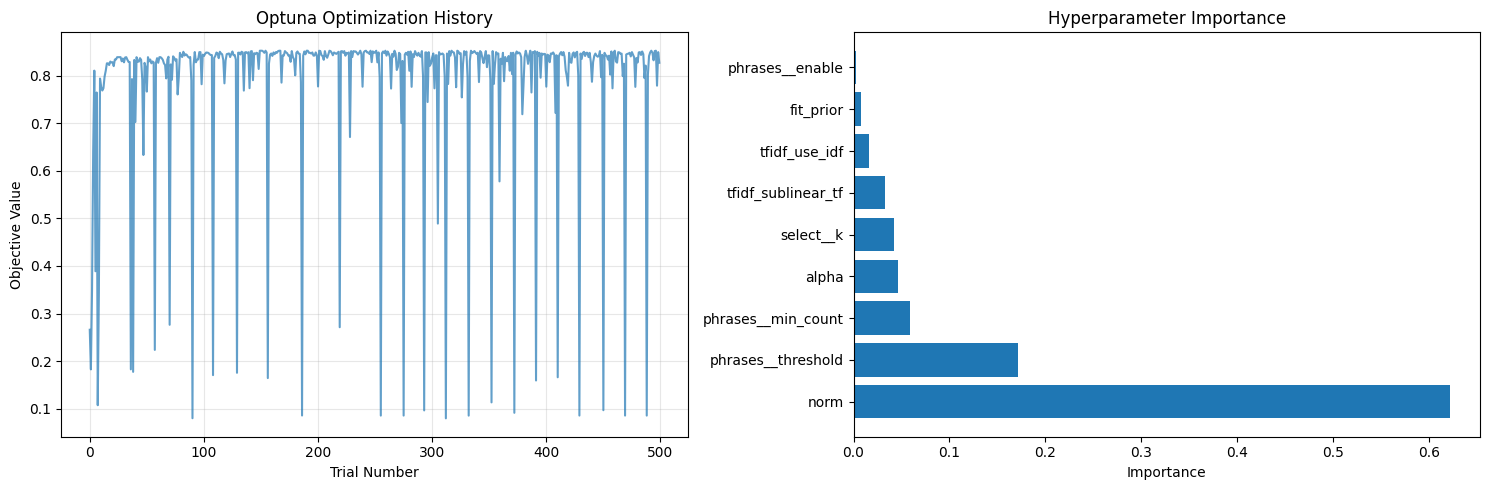


2. Parameter Value Distributions:


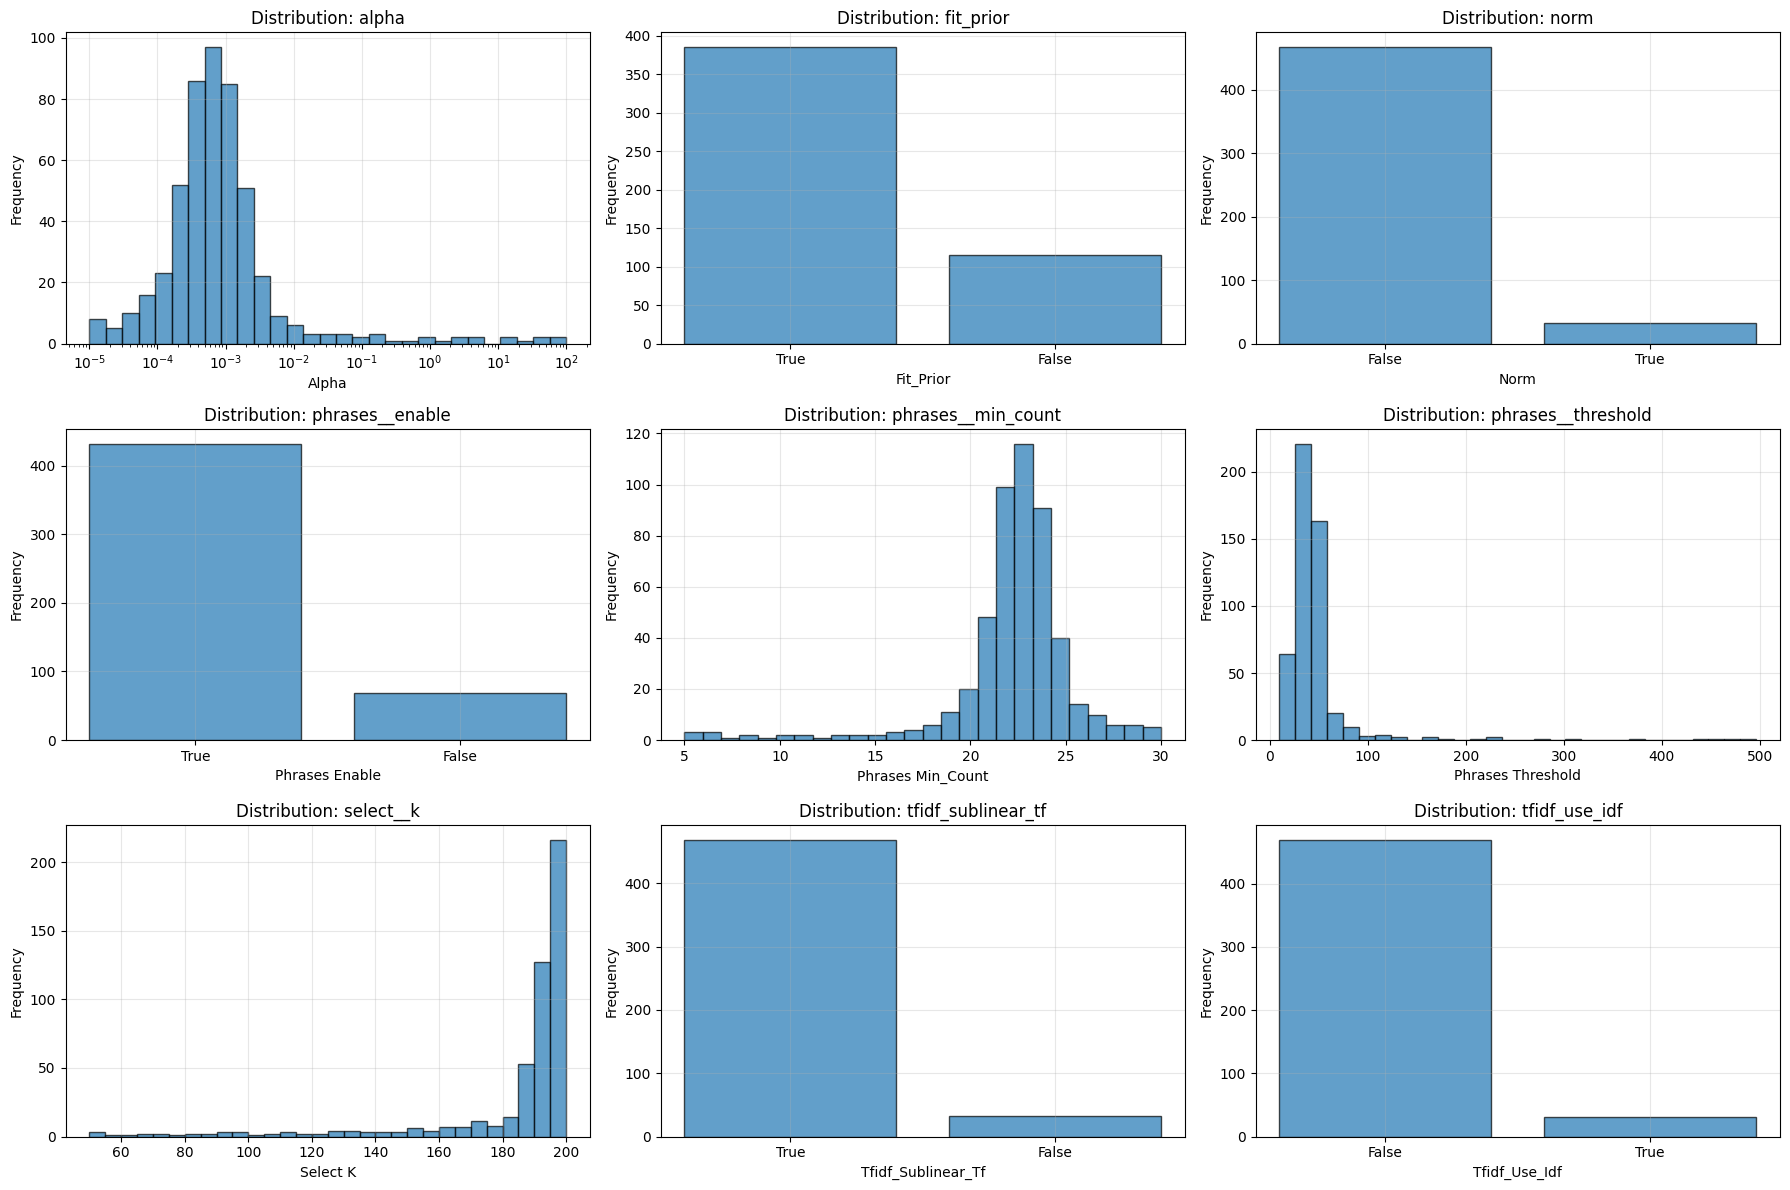


3. Performance vs Individual Parameters:


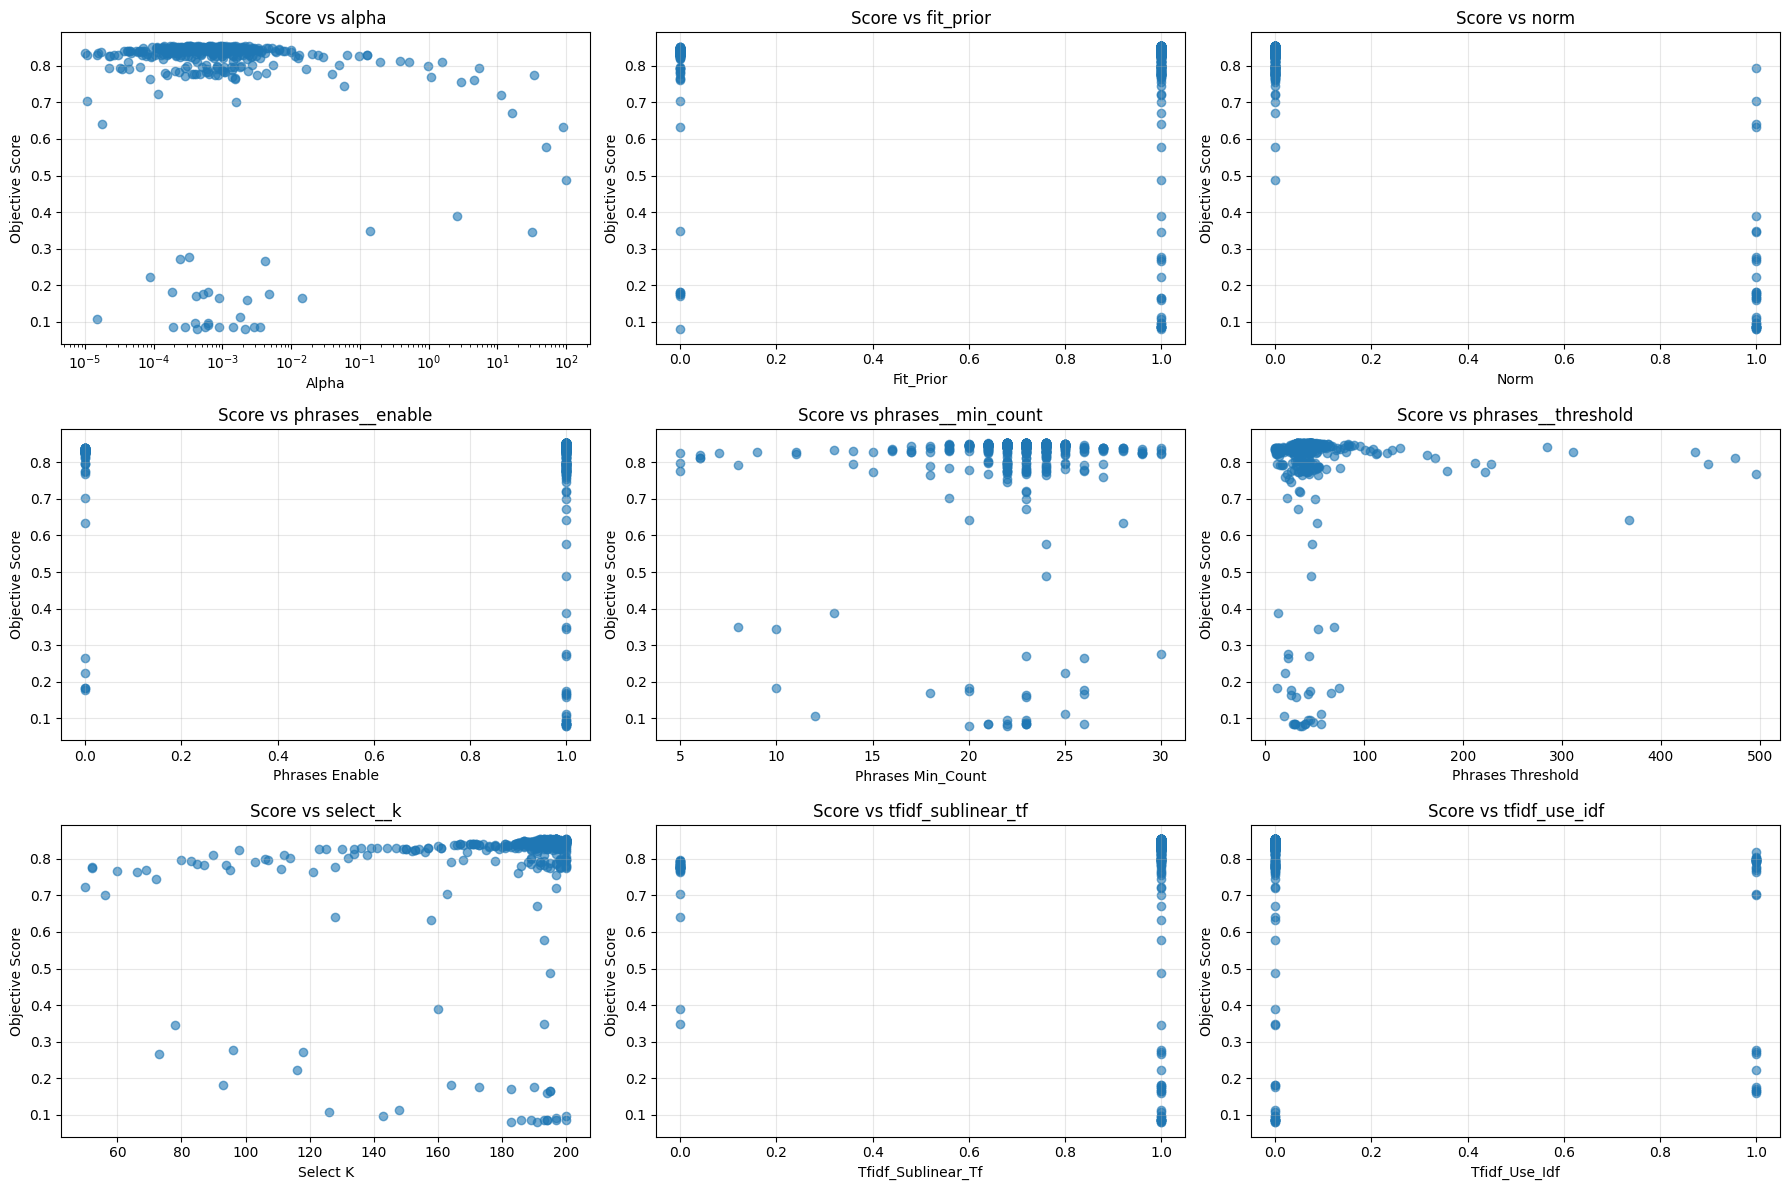


4. Convergence Analysis:


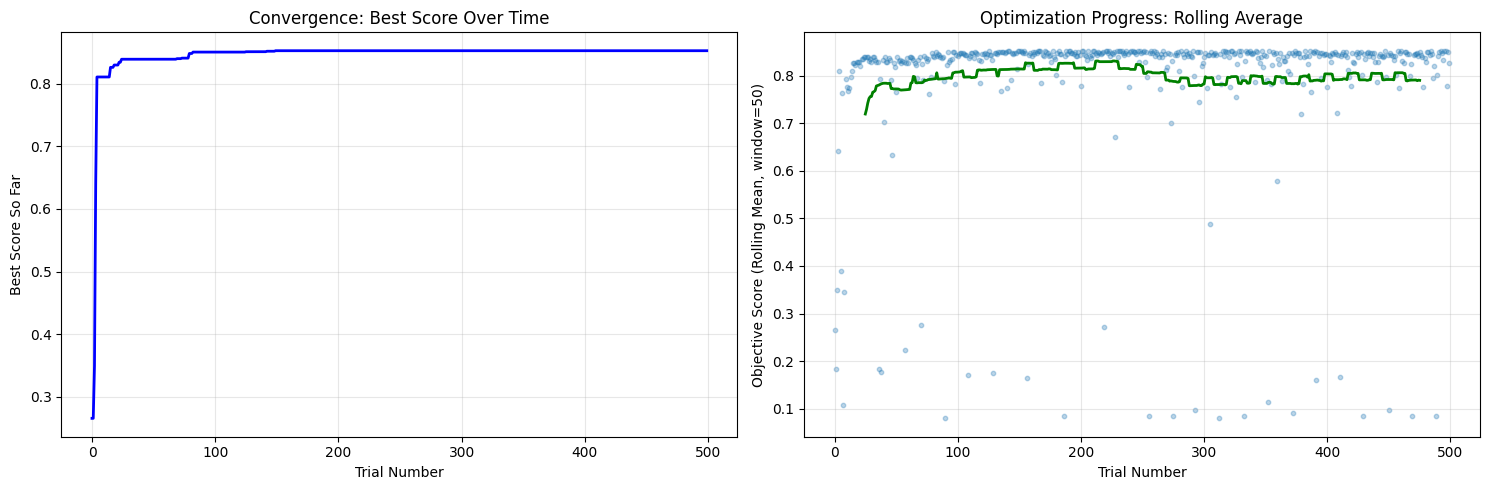


5. Trial Status Overview:


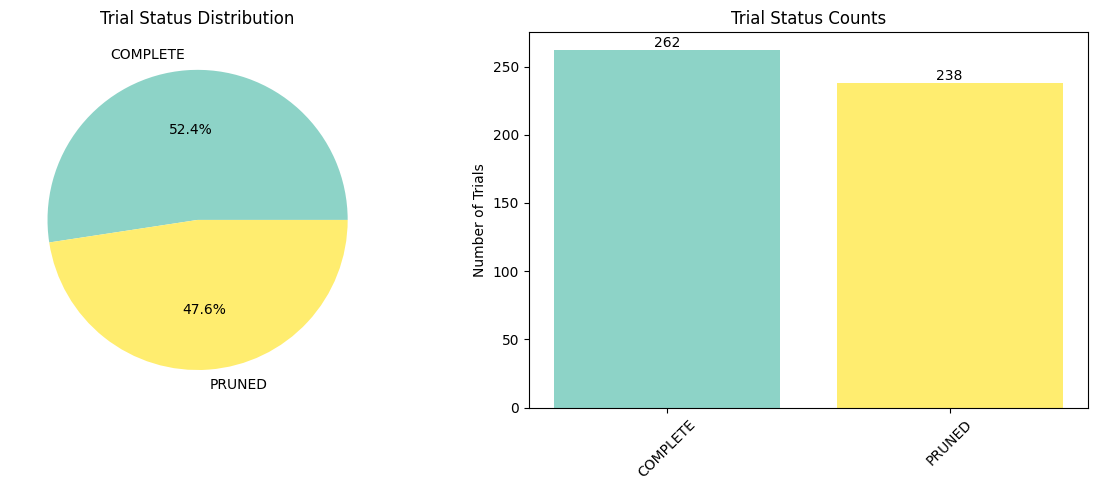


6. Top 10 Best Trials:
Rank Trial#  Score      alpha        fit_prior    norm         enable       min_count    threshold    k            tfidf_sublinear_tf tfidf_use_idf
---------------------------------------------------------------------------------------------------------------------------------------------------
1    149     0.8526     0.0003       True         False        True         24           31.7366      194          True         False       
2    237     0.8526     0.0003       True         False        True         23           36.0625      192          True         False       
3    259     0.8526     0.0005       True         False        True         24           32.1918      196          True         False       
4    267     0.8526     0.0016       True         False        True         23           35.3844      195          True         False       
5    317     0.8526     0.0003       True         False        True         24           32.0772      195          T

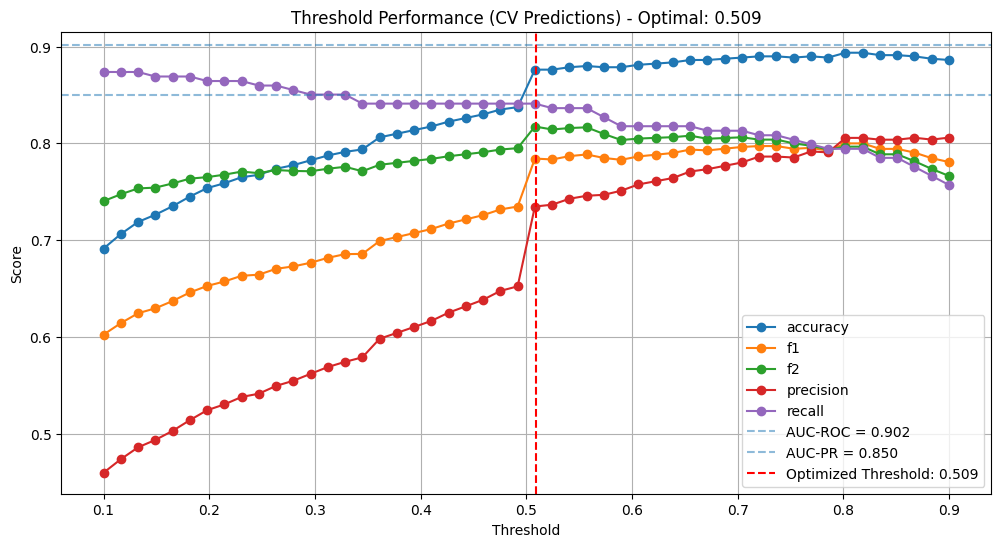

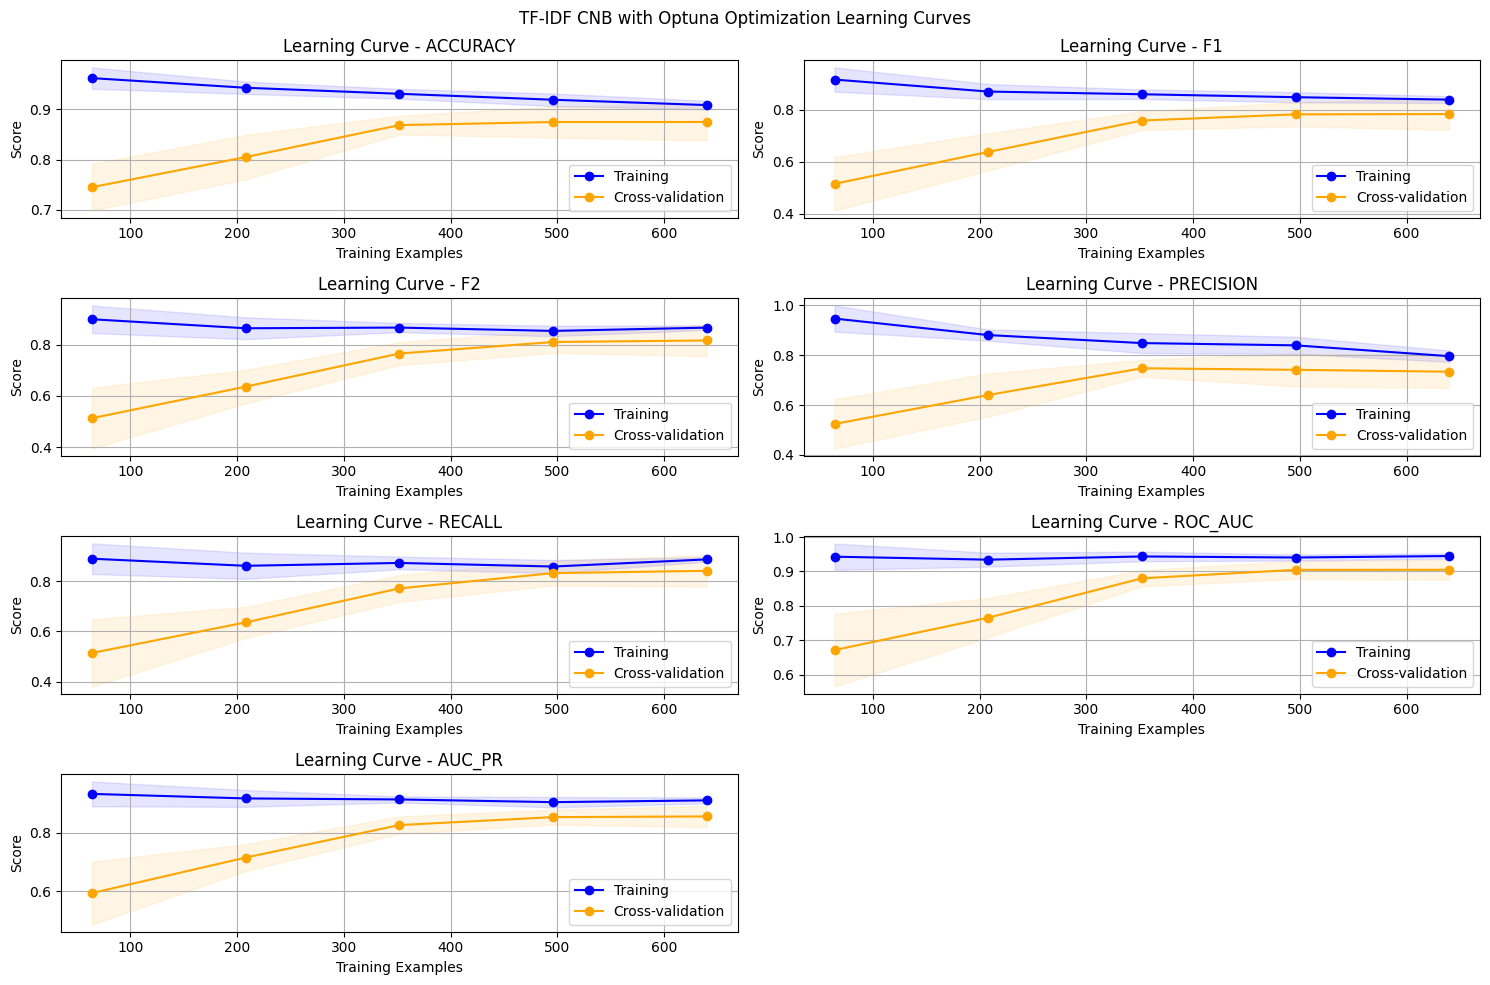


Final Threshold: 0.51

Test Set Performance:
              precision    recall  f1-score   support

           0       0.93      0.88      0.90       146
           1       0.71      0.83      0.77        54

    accuracy                           0.86       200
   macro avg       0.82      0.86      0.84       200
weighted avg       0.87      0.86      0.87       200

Additional Metrics:
Accuracy   0.865
F2-score   0.806
AUC-ROC    0.916
AUC-PR     0.868



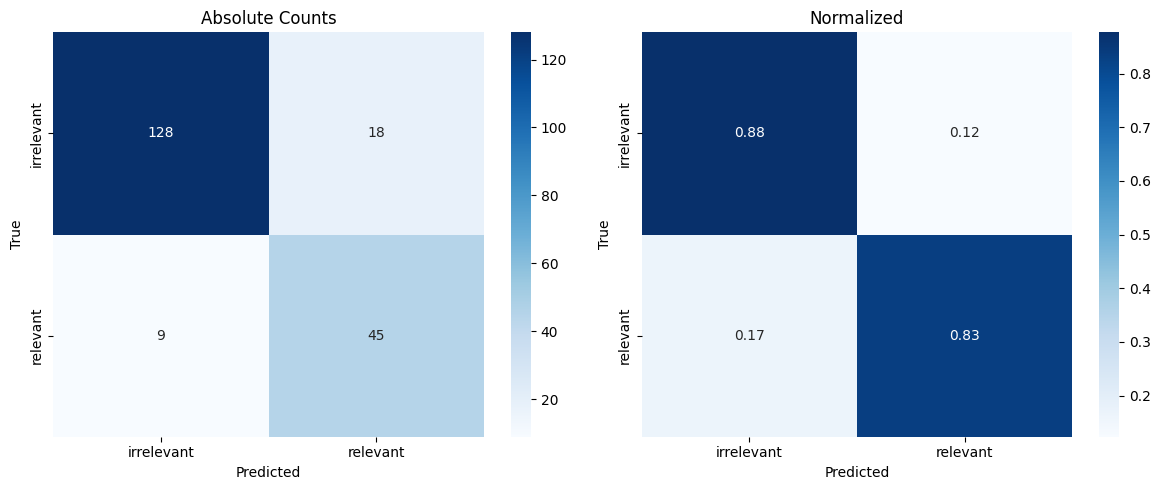

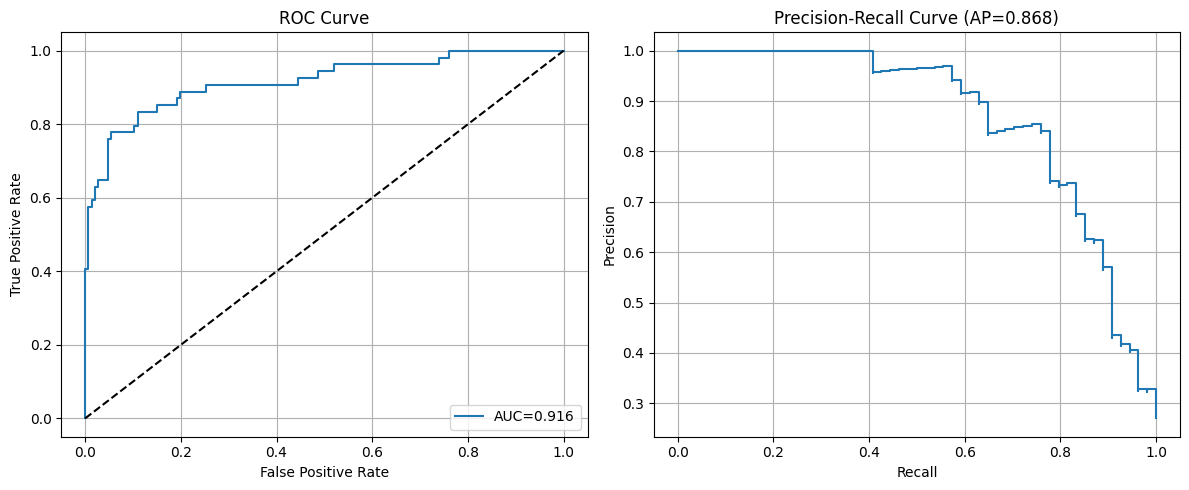


Model saved as 'model_tfidf_cnb_advanced.joblib'


In [13]:
# Define a pipeline: TF-IDF vectorization, chi2 feature selection, and a CNB classifier 
pipeline_tfidf_cnb = Pipeline([
    ("phrases", PhraseDetector(enable=True, min_count=10, threshold=300.0)),
    ("tfidf",   TfidfVectorizer(lowercase=True, norm=None, use_idf=False, sublinear_tf=True)), #The multinomial distribution normally requires integer feature counts. sklearn
    ("select",  SelectKBest(score_func=chi2, k=2000)),
    ("clf",     ComplementNB(
                    alpha=1.0, #will be optimized during optuna
                    fit_prior=True, #will be optimized during optuna
                    norm=False #will be optimized during optuna   
                ))
])

# CV Strategy (consistent across all sections)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define parameter space for Optuna optimization
param_space = {
    "clf__alpha": lambda trial: trial.suggest_float("alpha", 1e-5, 1e+2, log=True),
    "clf__fit_prior": lambda trial: trial.suggest_categorical("fit_prior", [True, False]),
    "clf__norm": lambda trial: trial.suggest_categorical("norm", [True, False]),
    "select__k": lambda trial: trial.suggest_int("select__k", 50, 200), #widened after first runs and visuals from 50 to 150 to 1 to 150
    "tfidf__use_idf":      lambda t: t.suggest_categorical("tfidf_use_idf", [False, True]),
    "tfidf__sublinear_tf": lambda t: t.suggest_categorical("tfidf_sublinear_tf", [False, True]),
    "phrases__enable":      lambda t: t.suggest_categorical("phrases__enable", [True, False]),
    "phrases__min_count":   lambda t: t.suggest_int("phrases__min_count", 5, 30),
    "phrases__threshold":   lambda t: t.suggest_float("phrases__threshold", 10.0, 500.0, log=True)
}

# Execute Optuna optimization with TPE sampler
best_model, best_params, study = optimize_with_optuna(
    estimator=pipeline_tfidf_cnb,
    param_space=param_space,
    X=X_dev, 
    y=y_dev,
    cv=cv,
    n_trials=500,  # Intelligent search with early stopping
    direction="maximize",
    n_jobs=-1,
    random_state=42,
    verbose=False,  # No console output, only file logging
    log_to_file=True,
    model_name="tfidf_cnb_advanced"
)

print("Best parameters found by Optuna TPE:", best_params)
print(f"Best F2 score during optimization: {study.best_value:.3f}")

# Show optimization history/statistics
plot_optuna_study_analysis(study)

# Extract the base model for threshold optimization
base_model = best_model

# Proper threshold optimization with nested CV using consistent CV strategy
print("\nOptimizing threshold with nested cross-validation (coarse-to-fine)...")
tuned_model, threshold_results = optimize_threshold_with_cv(
    base_estimator=base_model,
    X=X_dev,
    y=y_dev,
    scoring='f2',
    cv=cv,  # Use same CV strategy as hyperparameter optimization for consistency
    thresholds=50,
    coarse_to_fine=True,
    fine_range_factor=0.15,
    n_jobs=-1,
    random_state=42
)

print(f"Optimized threshold: {threshold_results['best_threshold']:.3f}")
print(f"CV F2-score with optimized threshold: {threshold_results['cv_score']:.3f}")

# Unbiased threshold visualization using consistent CV strategy
print("\nGenerating unbiased threshold visualization...")

viz_data_cv = get_threshold_evaluation_data_cv(
    base_estimator=base_model,
    X=X_dev, 
    y=y_dev,
    cv=cv  # Use same CV for visualization consistency
)

plot_threshold_curves(viz_data_cv)
plt.title(f'Threshold Performance (CV Predictions) - Optimal: {threshold_results["best_threshold"]:.3f}')
plt.axvline(x=threshold_results['best_threshold'], color='red', linestyle='--', 
           label=f'Optimized Threshold: {threshold_results["best_threshold"]:.3f}')
plt.legend()
plt.show()

# Learning curves analysis
plot_learning_curves(
    base_model, X_dev, y_dev,  # Use base model for learning curves
    cv=cv,
    figsize=(15, 10)
)
plt.suptitle('TF-IDF CNB with Optuna Optimization Learning Curves')
plt.tight_layout()
plt.show()

# Final evaluation on test set using the tuned model
y_test_pred = tuned_model.predict(X_test)  # Uses optimized threshold automatically
y_test_proba = tuned_model.predict_proba(X_test)[:, 1] #predict_proba available for NB

print(f"\nFinal Threshold: {threshold_results['best_threshold']:.2f}")
print("\nTest Set Performance:")
test_report_str = extended_classification_report(y_test, y_test_pred, y_test_proba)
print(test_report_str)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
plot_confusion_matrix(y_test, y_test_pred, normalize=False, ax=ax1, title='Absolute Counts')
plot_confusion_matrix(y_test, y_test_pred, normalize=True,  ax=ax2, title='Normalized')
plt.tight_layout()
plt.show()

# ROC and Precision-Recall curves
plot_roc_and_pr_curves(y_test, y_test_proba)
plt.show()

# Extract structured test performance metrics using modular approach
test_metrics = get_metrics_dict(y_test, y_test_pred, y_test_proba)

# For completeness, also get CV performance metrics (using dummy data for CV report format)
# Note: We use y_dev here as representative CV data since actual CV predictions aren't stored
cv_pred_dummy = base_model.predict(X_dev)
cv_proba_dummy = base_model.predict_proba(X_dev)[:, 1] #predict_proba available for NB
cv_metrics = get_metrics_dict(y_dev, cv_pred_dummy, cv_proba_dummy)

# Create comprehensive results summary
results_summary = {
    'model_name': 'TF-IDF + CNB',
    'preprocessing_type': 'advanced',
    'optimization_method': 'Optuna TPE + TunedThresholdClassifierCV',
    'best_params': best_params,
    'cv_results': {
        'best_f2_score': study.best_value,
        'optimized_threshold': threshold_results['best_threshold'],
        'cv_f2_with_threshold': threshold_results['cv_score'],
        'cv_performance_metrics': cv_metrics  # Representative CV performance
    },
    'test_results': {
        'threshold_used': threshold_results['best_threshold'], 
        'test_performance_metrics': test_metrics,  # Complete test performance
        'formatted_report': test_report_str  # Human-readable report
    },
    'dataset_info': {
        'train_size': len(X_dev),
        'test_size': len(X_test),
        'train_positive_ratio': y_dev.mean(),
        'test_positive_ratio': y_test.mean()
    }
}

# Save the properly tuned model with comprehensive results
dump({
    'model': tuned_model,  # This includes the optimized threshold
    'base_model': base_model,  # Original model without threshold optimization
    'threshold': threshold_results['best_threshold'],
    'cv_score': threshold_results['cv_score'],
    'best_params': best_params,
    'search_type': 'Optuna TPE + TunedThresholdClassifierCV',
    'results_summary': results_summary  # Complete structured results for model comparison
}, "model_tfidf_cnb_advanced.joblib")

print(f"\nModel saved as 'model_tfidf_cnb_advanced.joblib'")